In [6]:
!pip install -q kagglehub tensorflow scikit-learn matplotlib

In [7]:
# !pip install -q kagglehub tensorflow scikit-learn matplotlib
import os, pandas as pd, numpy as np, json, math, re, random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("TF:", tf.__version__)


TF: 2.20.0


In [8]:
import kagglehub

# Downloads to a cache path; returns the local folder
path = kagglehub.dataset_download("saurabhshahane/ecommerce-text-classification")
print("Dataset path:", path)
print(os.listdir(path))


/Users/divyapandey/yolo_env312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████████████████████████████████| 7.86M/7.86M [00:02<00:00, 3.30MB/s]

Extracting files...


Dataset path: /Users/divyapandey/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76
['ecommerceDataset.csv']


In [9]:
# Try to pick the "main" file containing labels/categories + numeric text IDs
csvs = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
print("CSV files:", csvs)

# Heuristic: pick the smallest CSV as "mapping" and the largest as "main" if names are unclear
sizes = {f: os.path.getsize(os.path.join(path,f)) for f in csvs}
csvs_sorted = sorted(csvs, key=lambda x: sizes[x], reverse=True)

# Prefer known names if present
main_candidates = [n for n in csvs if n.lower() in {"train.csv","ecommerce_train.csv"}]
map_candidates  = [n for n in csvs if n.lower() in {"ecommercedataset.csv","product_descriptions.csv"}]

main_file = main_candidates[0] if main_candidates else csvs_sorted[0]
map_file  = map_candidates[0]  if map_candidates else (csvs_sorted[1] if len(csvs_sorted)>1 else None)

print("Chosen main_file:", main_file)
print("Chosen map_file :", map_file)

df = pd.read_csv(os.path.join(path, main_file))
desc_df = pd.read_csv(os.path.join(path, map_file)) if map_file else None

print("Main head:\n", df.head(3))
if desc_df is not None:
    print("Map head:\n", desc_df.head(3))


CSV files: ['ecommerceDataset.csv']
Chosen main_file: ecommerceDataset.csv
Chosen map_file : ecommerceDataset.csv
Main head:
    Household  \
0  Household   
1  Household   
2  Household   

  Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resis

In [ ]:
import kagglehub, os
path = kagglehub.dataset_download("saurabhshahane/ecommerce-text-classification")
print("Dataset path:", path)
print(os.listdir(path))

Dataset path: /Users/divyapandey/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76
['ecommerceDataset.csv']


In [12]:
# 0) Imports
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("TF:", tf.__version__)

# 1) Use your detected path
path = "/Users/divyapandey/.cache/kagglehub/datasets/saurabhshahane/ecommerce-text-classification/versions/76"
assert os.path.exists(path)
print(os.listdir(path))


TF: 2.20.0
['ecommerceDataset.csv']


In [13]:
# 2) Load CSV correctly (dataset has no header row)
csv_file = "ecommerceDataset.csv"
df = pd.read_csv(os.path.join(path, csv_file), header=None, names=["Label","Text"])
print(df.head(3), "\nshape:", df.shape)

# Basic clean-up
df = df.dropna(subset=["Label","Text"])
df["Label"] = df["Label"].astype(str).str.strip()
df["Text"]  = df["Text"].astype(str).str.strip()

print("classes:", df["Label"].unique())
print("n_classes:", df["Label"].nunique())


       Label                                               Text
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain... 
shape: (50425, 2)
classes: ['Household' 'Books' 'Clothing & Accessories' 'Electronics']
n_classes: 4


In [14]:
# 3) Encode labels -> integers [0..C-1]
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
num_classes = int(df["Label"].nunique())
print("encoded classes:", num_classes, list(le.classes_))


encoded classes: 4 ['Books', 'Clothing & Accessories', 'Electronics', 'Household']


In [15]:
# (optional) reproducibility
import tensorflow as tf, numpy as np, random, os
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [16]:
# EarlyStopping to keep runs stable
cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)


In [20]:
vocab_size = 20000
max_len = 200
num_classes = int(df["Label"].nunique())


In [24]:
# Tokenize and pad text before training
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split

X = df["Text"].astype(str)
y = df["Label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Sample text:", X_train.iloc[0][:200])



Train size: 40339 Test size: 10085
Sample text: Rearming hinduism: 1 Review "While the name of the book Rearming Hinduism may give the appearance of militancy, this book is anything but that. It is a wise and passionate take on a much misunderstood


In [21]:
# Define model builder
def create_model(optimizer):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 128),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
max_len = 200

tok = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(X_train)

Xtr = pad_sequences(tok.texts_to_sequences(X_train), maxlen=max_len)
Xte = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=max_len)

print("Xtr:", Xtr.shape, "Xte:", Xte.shape)


Xtr: (40339, 200) Xte: (10085, 200)


In [27]:
# Train with multiple optimizers
optimizers = {
    "SGD": tf.keras.optimizers.SGD(),
    "Adam": tf.keras.optimizers.Adam(),
    "RMSProp": tf.keras.optimizers.RMSprop(),
    "Adagrad": tf.keras.optimizers.Adagrad(),
    "Nadam": tf.keras.optimizers.Nadam(),
}

EPOCHS, BATCH = 25, 32
histories, results, models = {}, {}, {}

for name, opt in optimizers.items():
    print(f"\n🔵 Training with: {name}")
    model = create_model(opt)
    h = model.fit(
        Xtr, y_train,
        validation_data=(Xte, y_test),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=1
    )
    histories[name] = h
    models[name] = model
    results[name] = {
        "final_val_acc": float(max(h.history["val_accuracy"])),
        "final_val_loss": float(min(h.history["val_loss"])),
    }

import pandas as pd, json
pd.DataFrame(results).T.sort_values("final_val_acc", ascending=False)



🔵 Training with: SGD
Epoch 1/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.3856 - loss: 1.3326 - val_accuracy: 0.4054 - val_loss: 1.3169
Epoch 2/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.4301 - loss: 1.2844 - val_accuracy: 0.4666 - val_loss: 1.2493
Epoch 3/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.5115 - loss: 1.1438 - val_accuracy: 0.5612 - val_loss: 1.0273
Epoch 4/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.5621 - loss: 1.0183 - val_accuracy: 0.5770 - val_loss: 0.9512
Epoch 5/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.5904 - loss: 0.9361 - val_accuracy: 0.5986 - val_loss: 0.9234
Epoch 6/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.6185 - loss: 0.8961 - val_accuracy: 0.5499 - val_loss: 0.9921
Epoch 7/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 77s 61ms/step - accuracy: 0.5833 - loss: 1.0015 - val_accuracy: 0.4816 - val_loss: 1.3881
Epoch 8/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 77s 61ms/ste

,final_val_acc,final_val_loss
Nadam,0.976401,0.146017
RMSProp,0.975310,0.145699
Adam,0.974814,0.149730
SGD,0.841249,0.524799
Adagrad,0.822013,0.575665


,final_val_acc,final_val_loss
Nadam,0.976401,0.146017
RMSProp,0.975310,0.145699
Adam,0.974814,0.149730
SGD,0.841249,0.524799
Adagrad,0.822013,0.575665


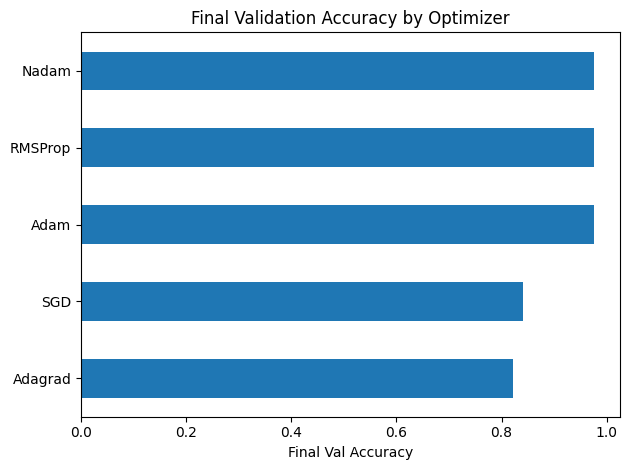

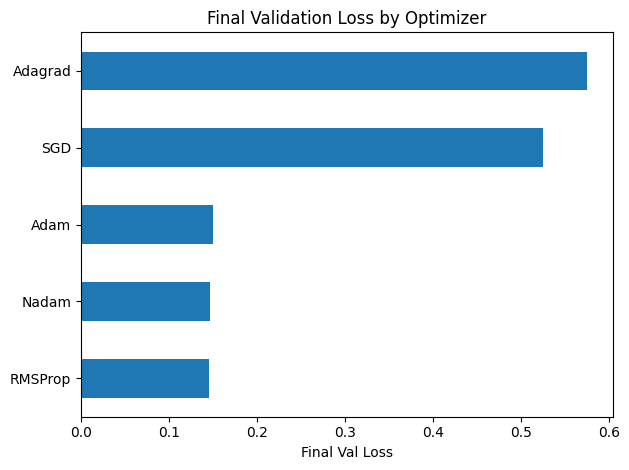

In [28]:
# ===== 1) Summary bars: final val_accuracy & val_loss =====
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.DataFrame(results).T  # index = optimizer name
display(res_df.sort_values("final_val_acc", ascending=False))

# Bar: final validation accuracy
plt.figure()
res_df.sort_values("final_val_acc")["final_val_acc"].plot(kind="barh")
plt.xlabel("Final Val Accuracy")
plt.title("Final Validation Accuracy by Optimizer")
plt.tight_layout()
plt.show()

# Bar: final validation loss
plt.figure()
res_df.sort_values("final_val_loss")["final_val_loss"].plot(kind="barh")
plt.xlabel("Final Val Loss")
plt.title("Final Validation Loss by Optimizer")
plt.tight_layout()
plt.show()


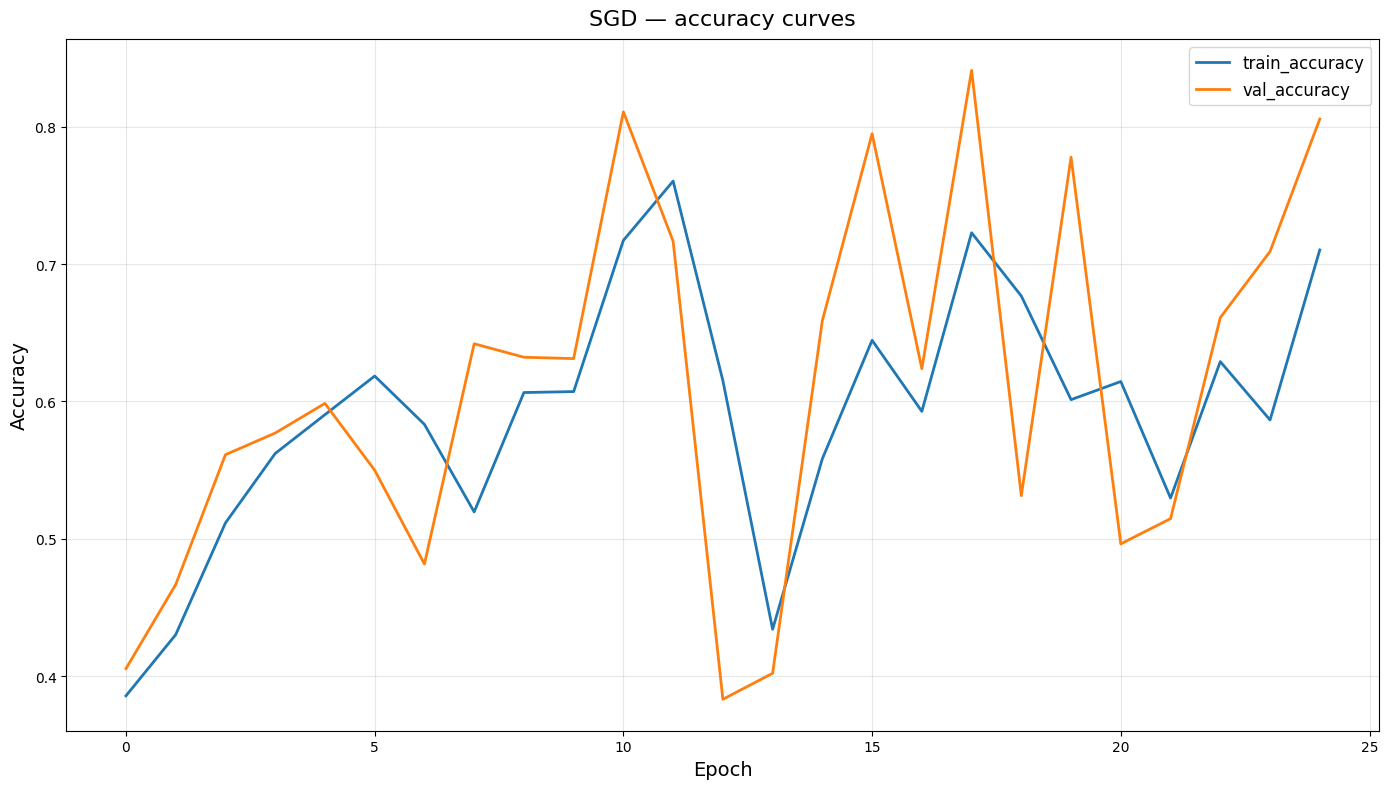

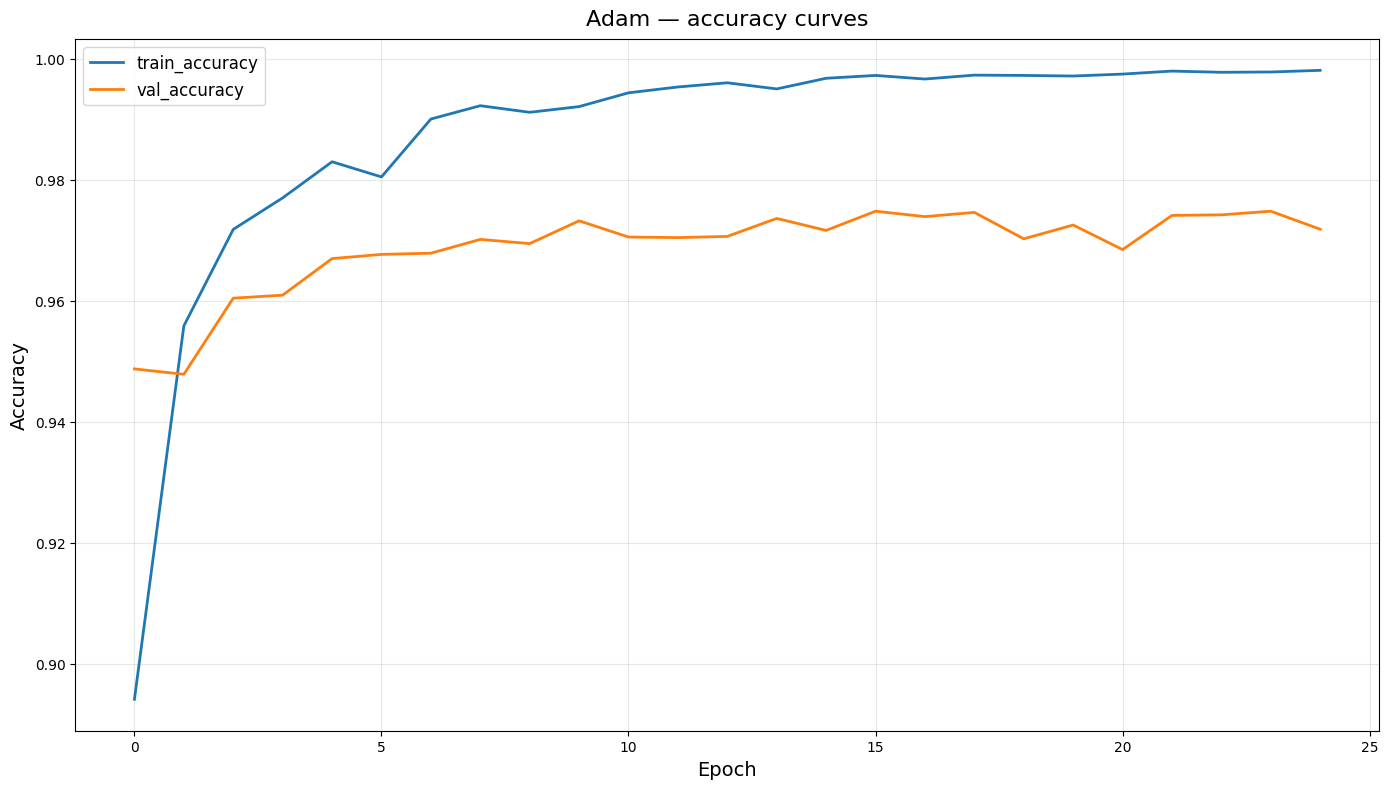

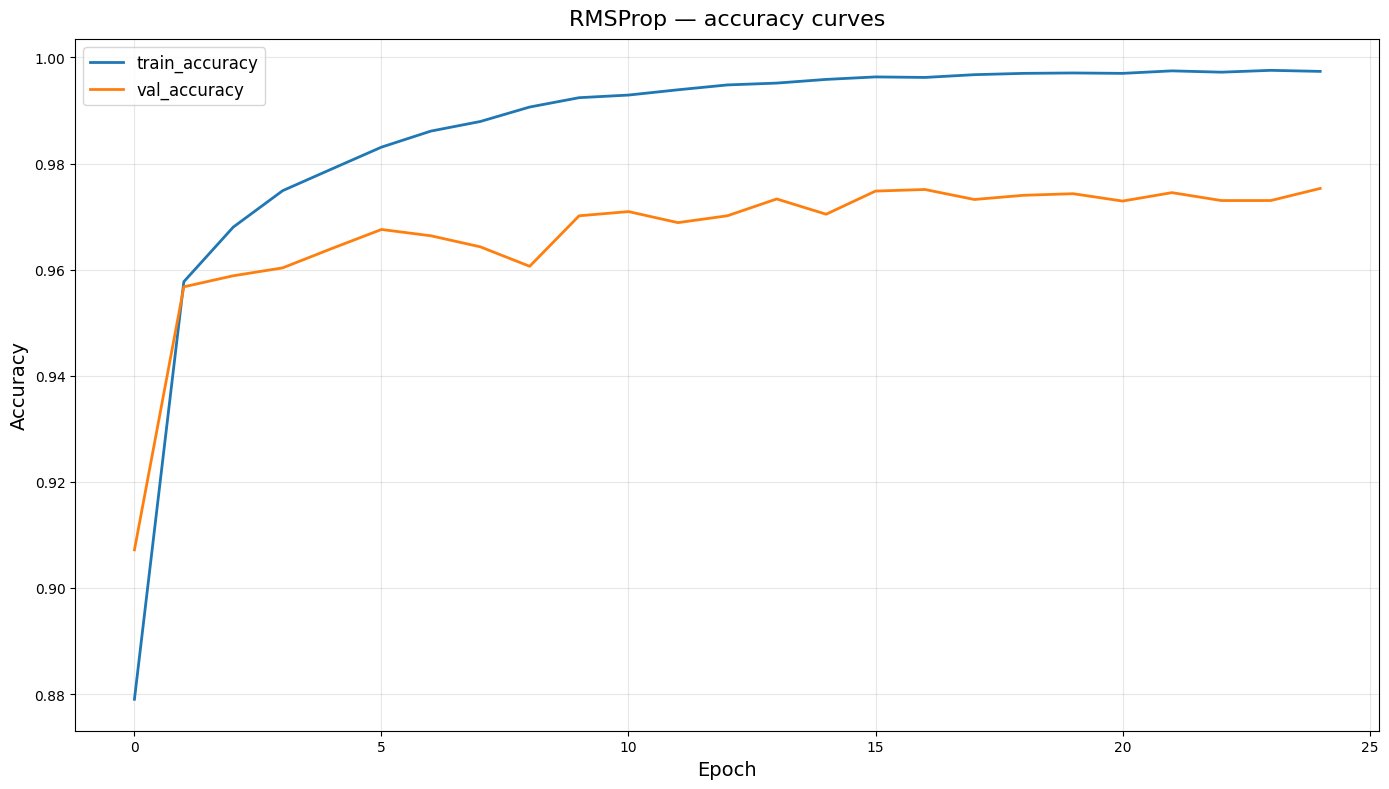

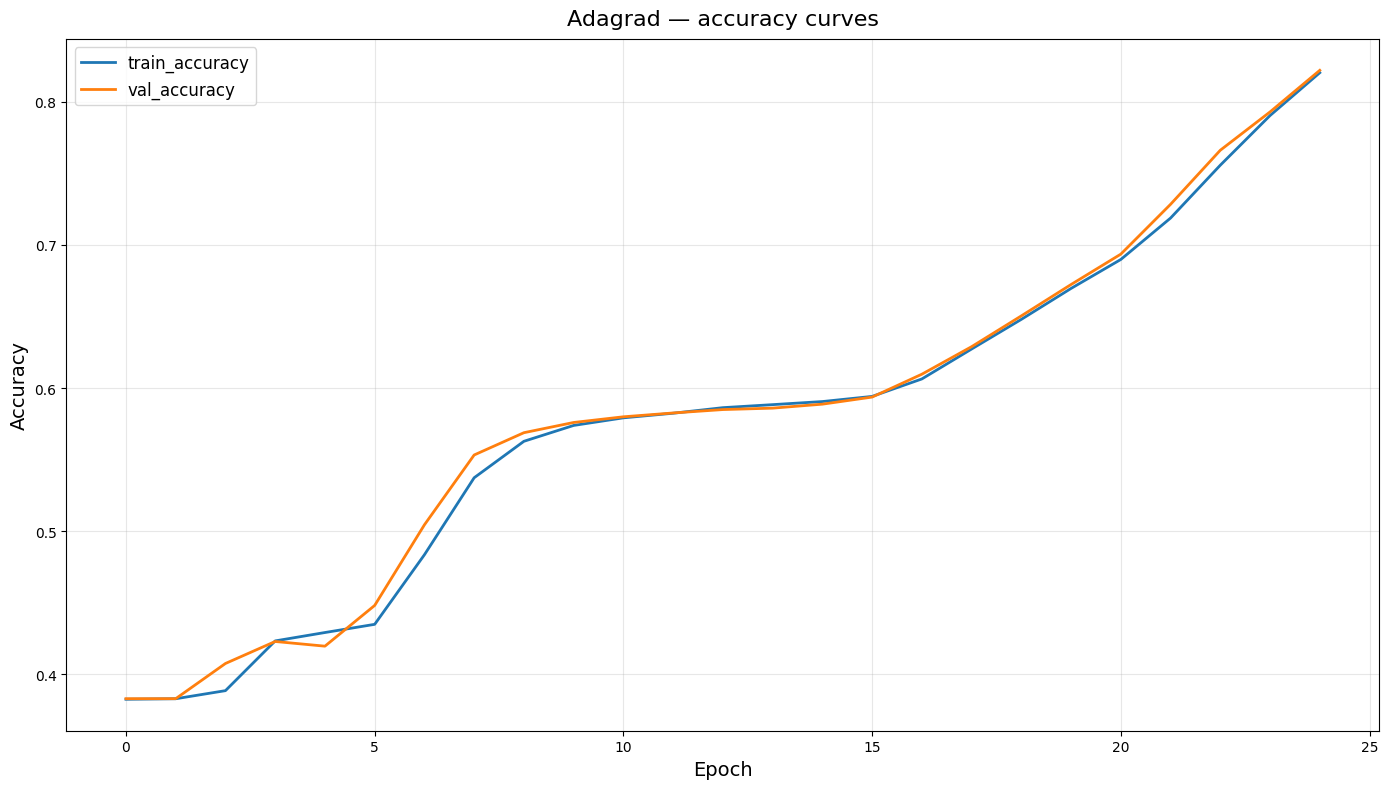

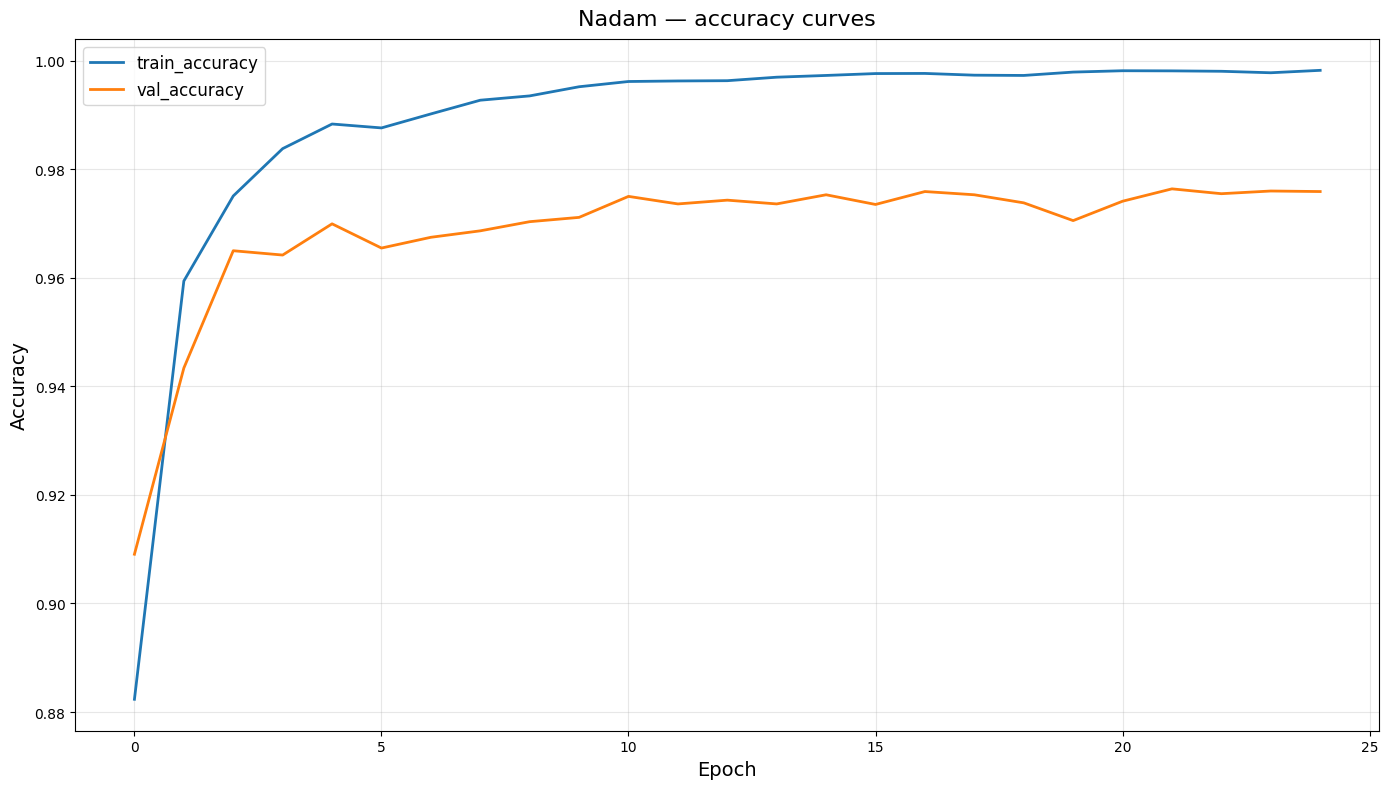

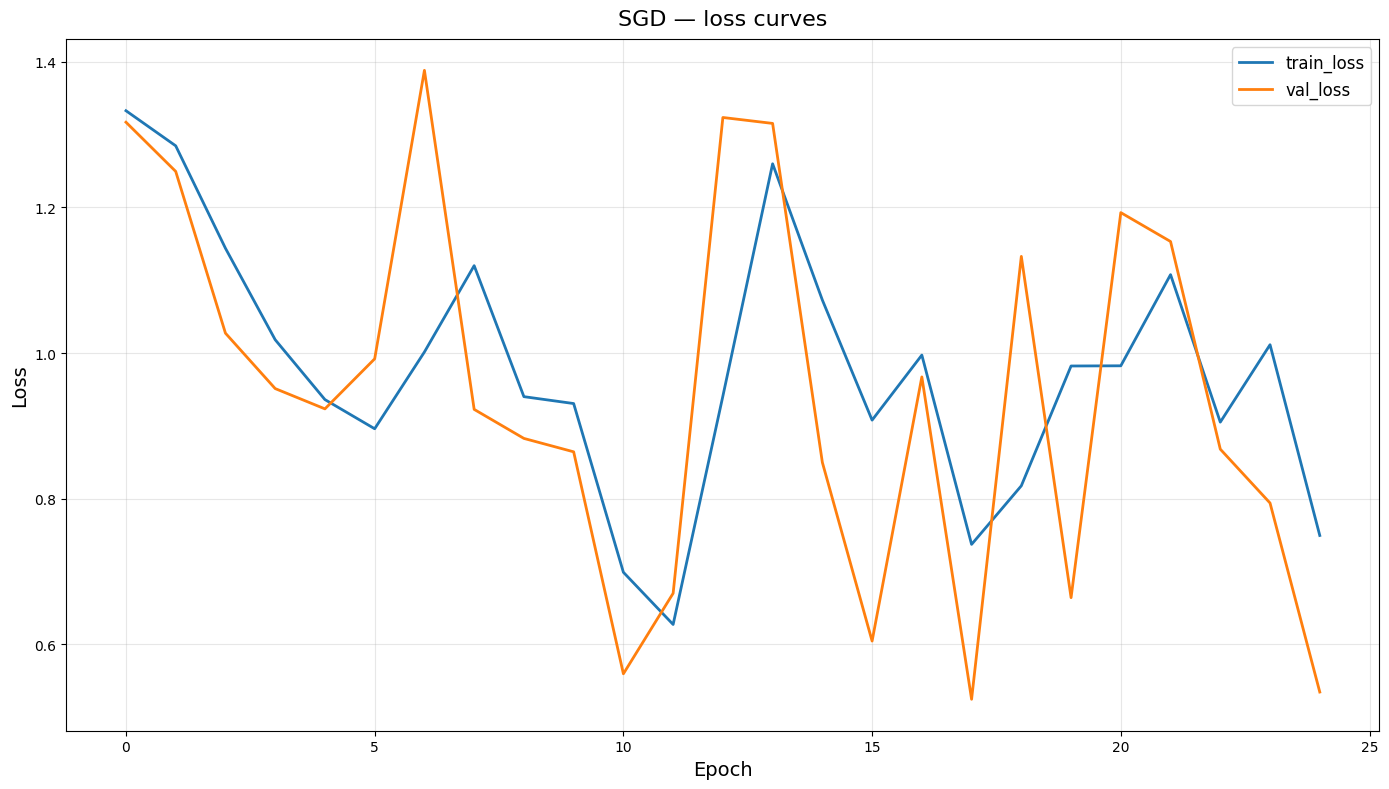

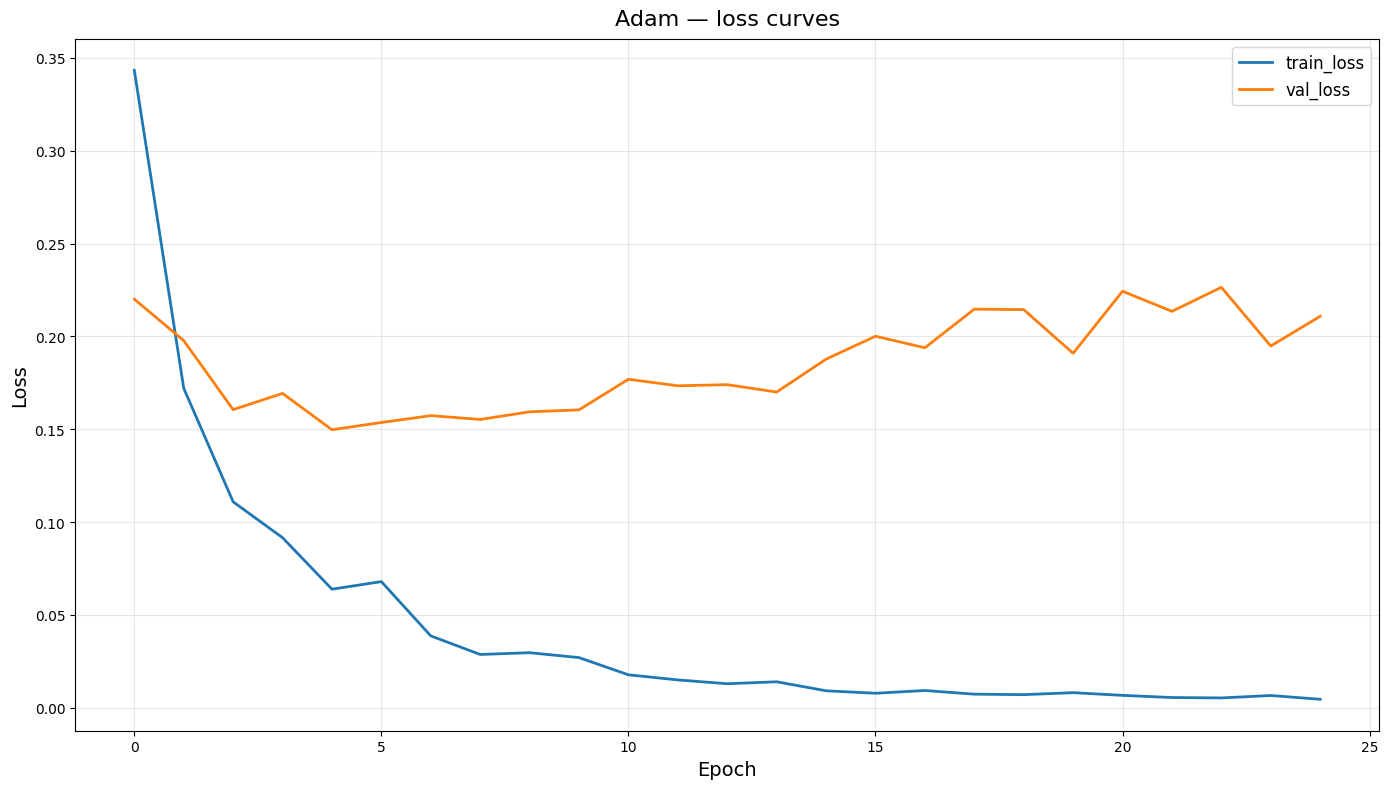

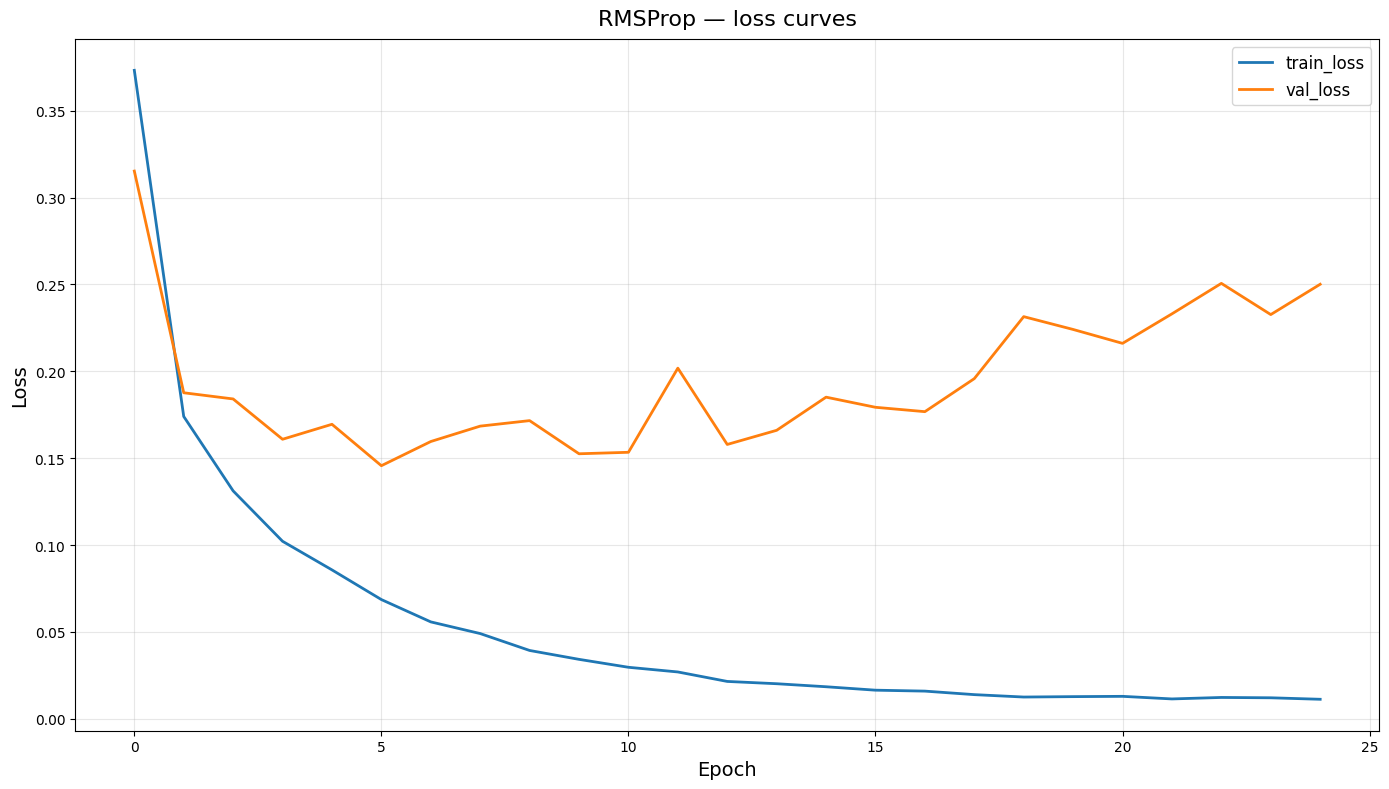

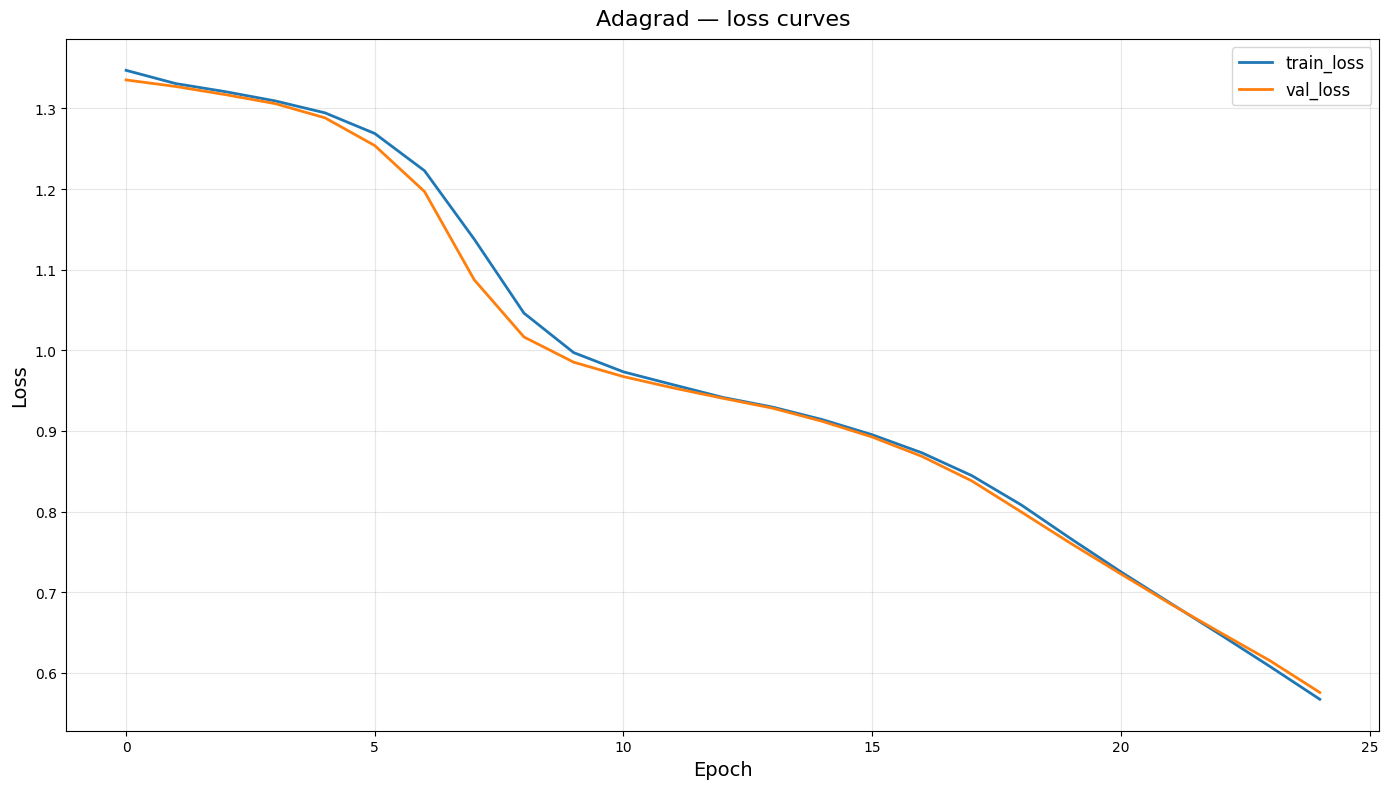

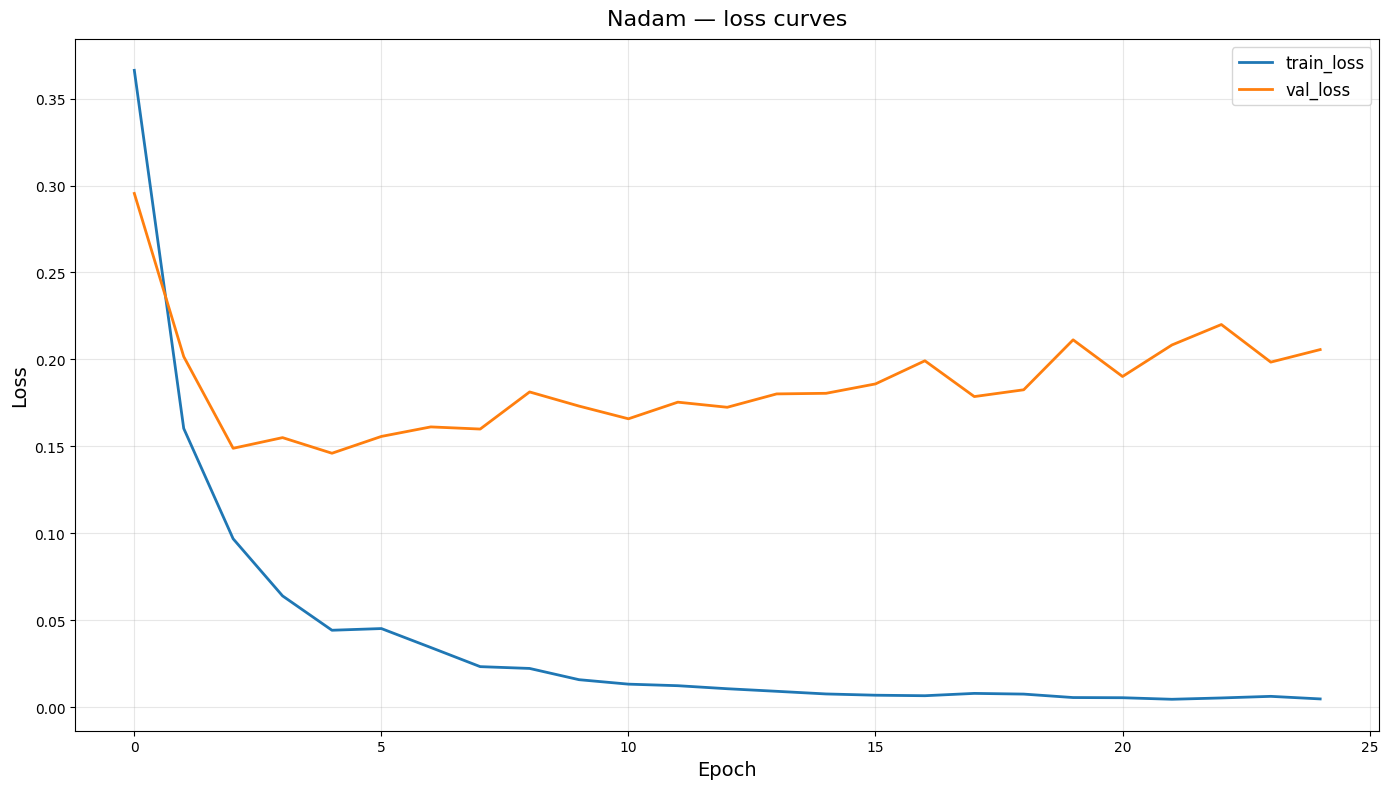

In [35]:
# ===== 2) Learning curves (train vs val) for EACH optimizer =====
import matplotlib.pyplot as plt

def plot_histories(histories, metric="accuracy"):
    val_metric = "val_" + metric
    for name, h in histories.items():
        plt.figure(figsize=(14, 8))   # <-- wider & taller view area
        plt.plot(h.history[metric], label=f"train_{metric}", linewidth=2)
        plt.plot(h.history[val_metric], label=f"{val_metric}", linewidth=2)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.title(f"{name} — {metric} curves", fontsize=16, pad=10)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_histories(histories, metric="accuracy")
plot_histories(histories, metric="loss")


✅ Saved: figs/SGD_accuracy_curve.png


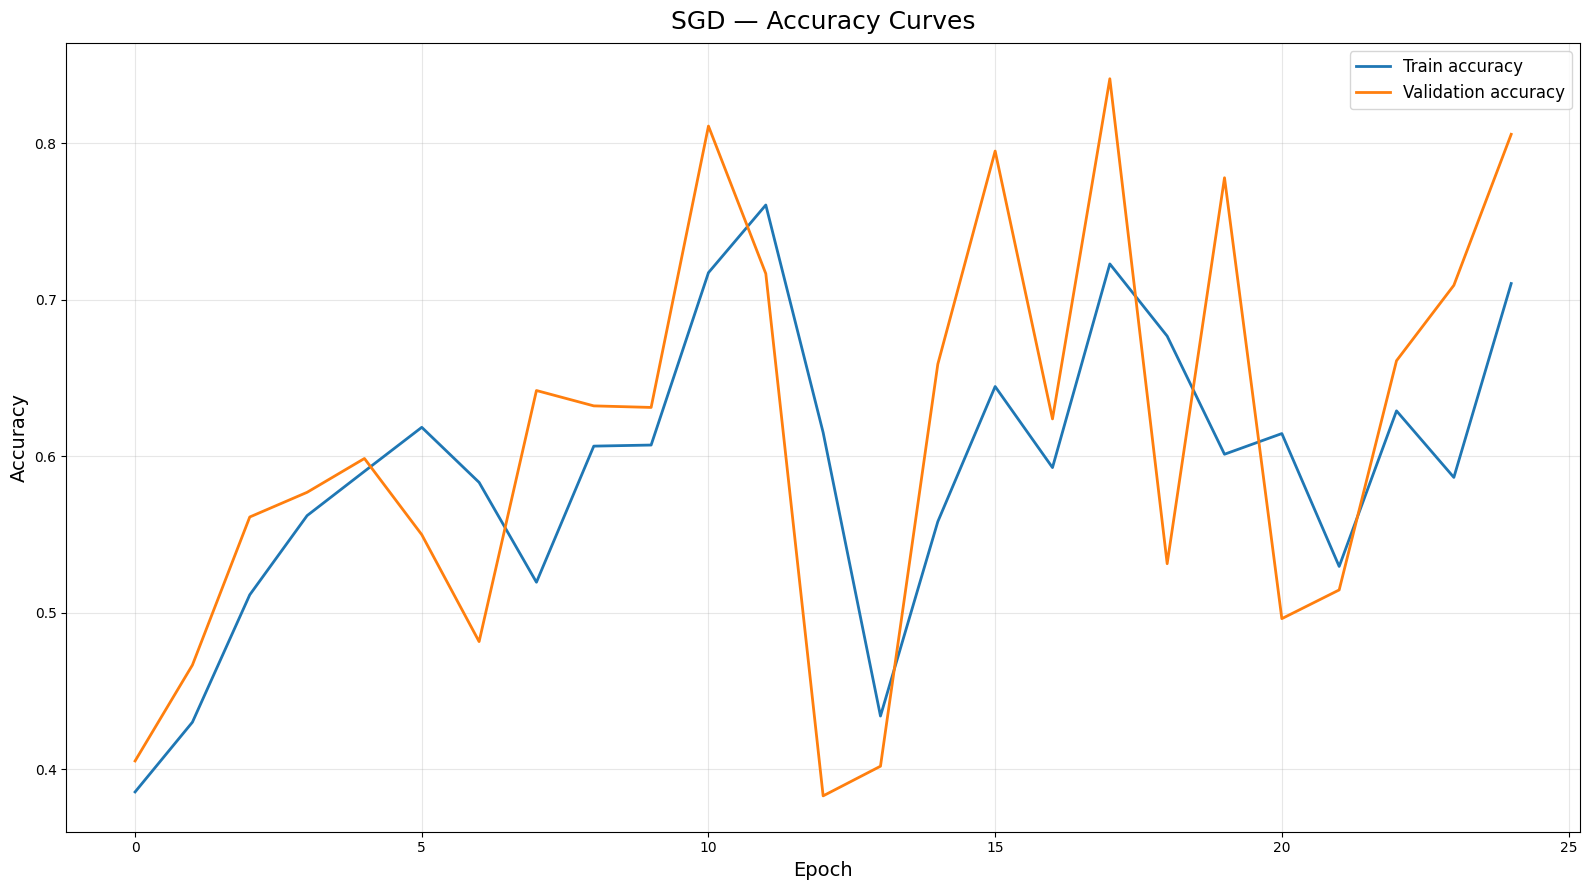

✅ Saved: figs/Adam_accuracy_curve.png


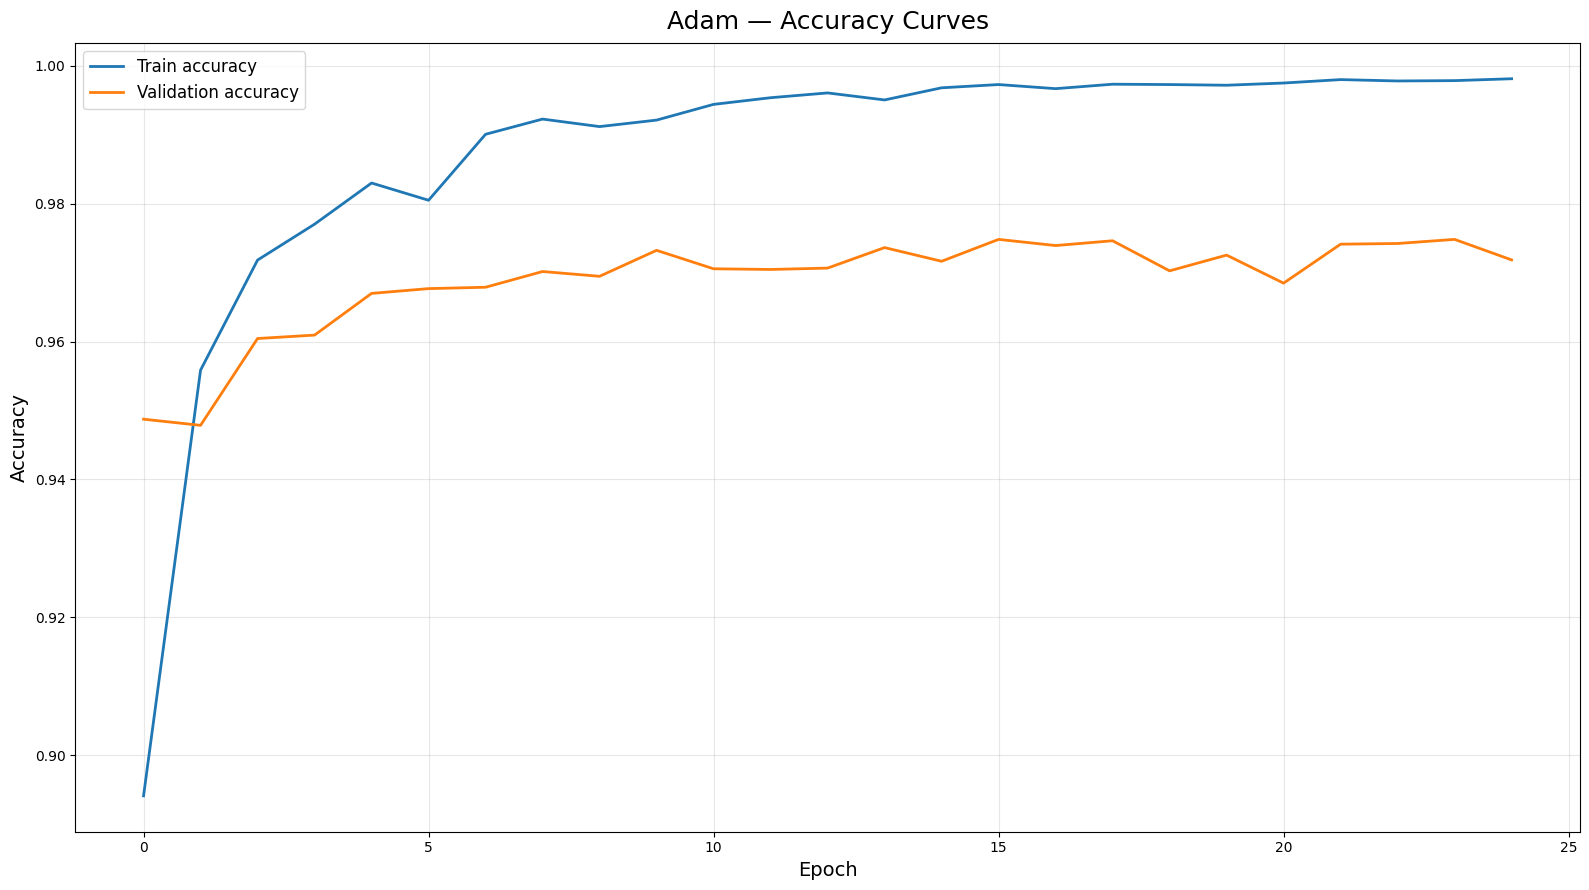

✅ Saved: figs/RMSProp_accuracy_curve.png


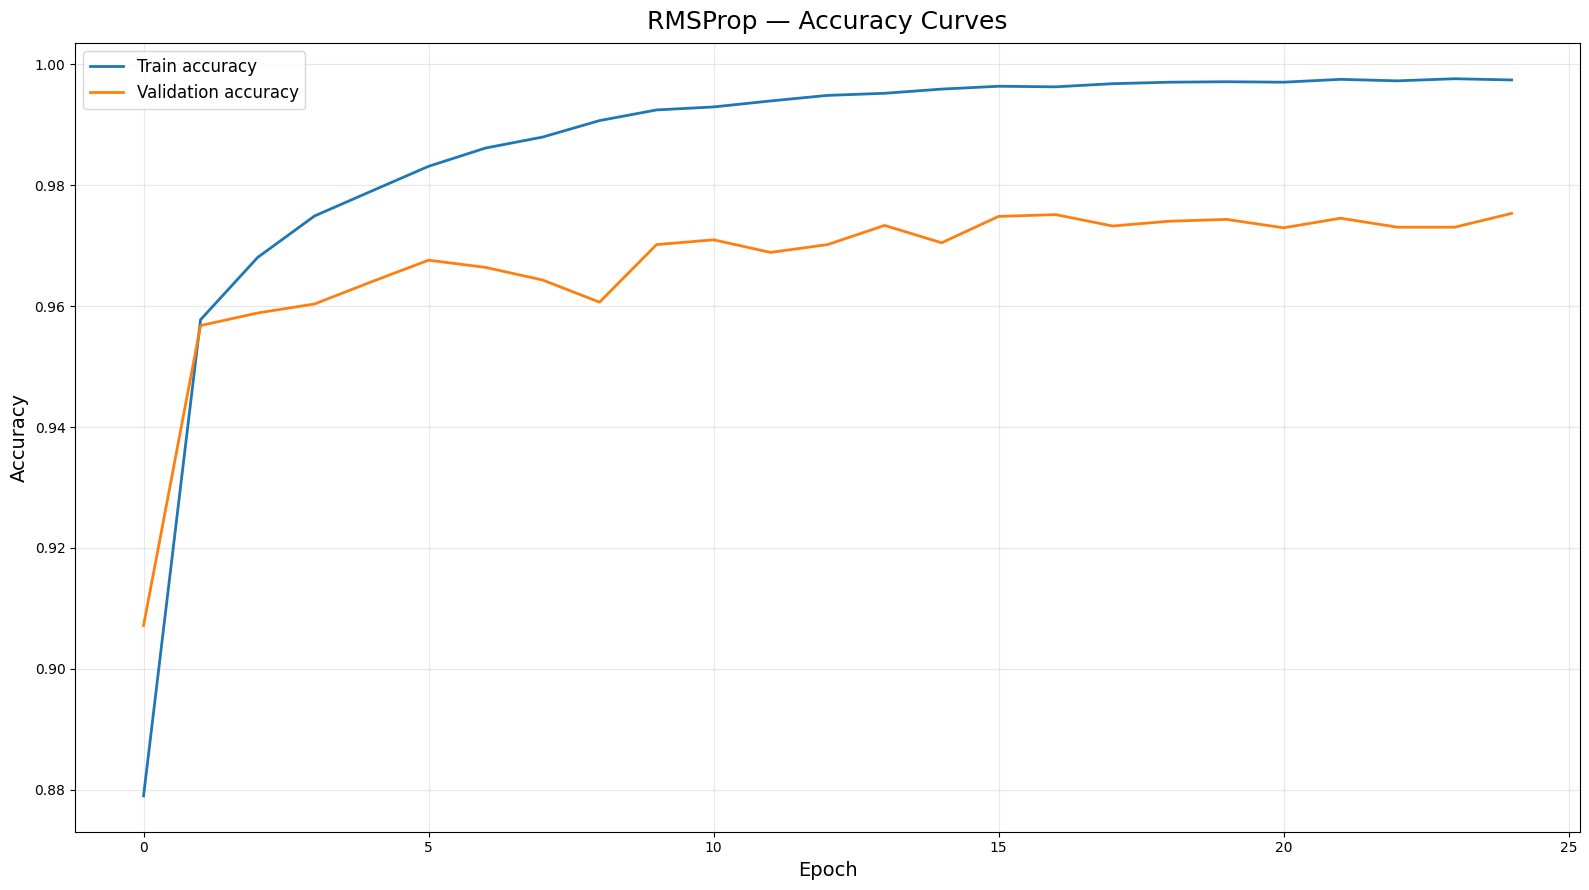

✅ Saved: figs/Adagrad_accuracy_curve.png


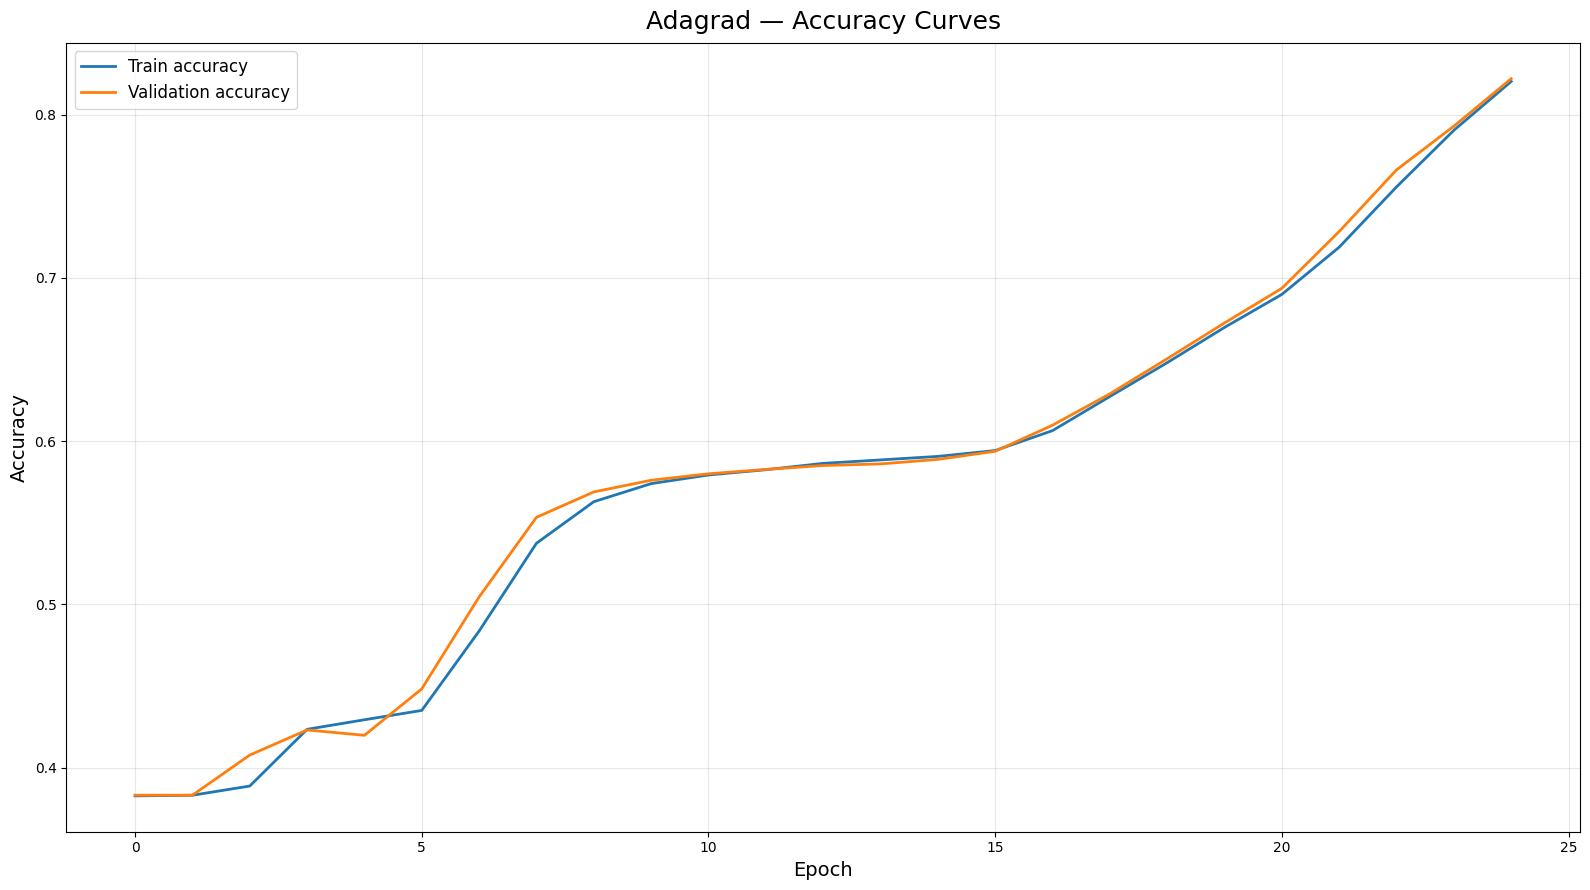

✅ Saved: figs/Nadam_accuracy_curve.png


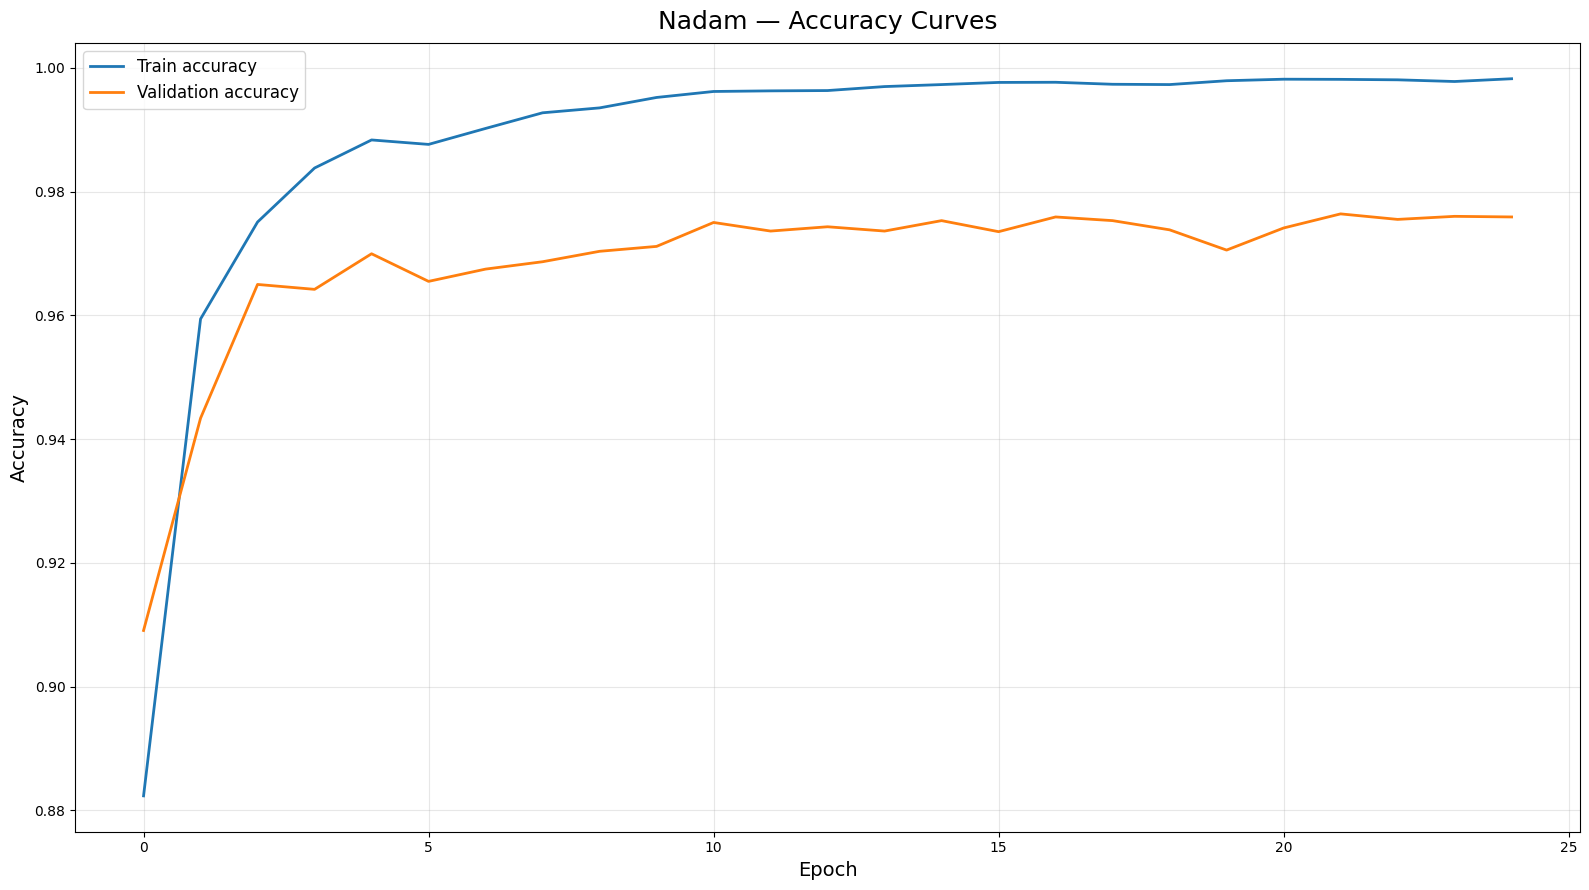

✅ Saved: figs/SGD_loss_curve.png


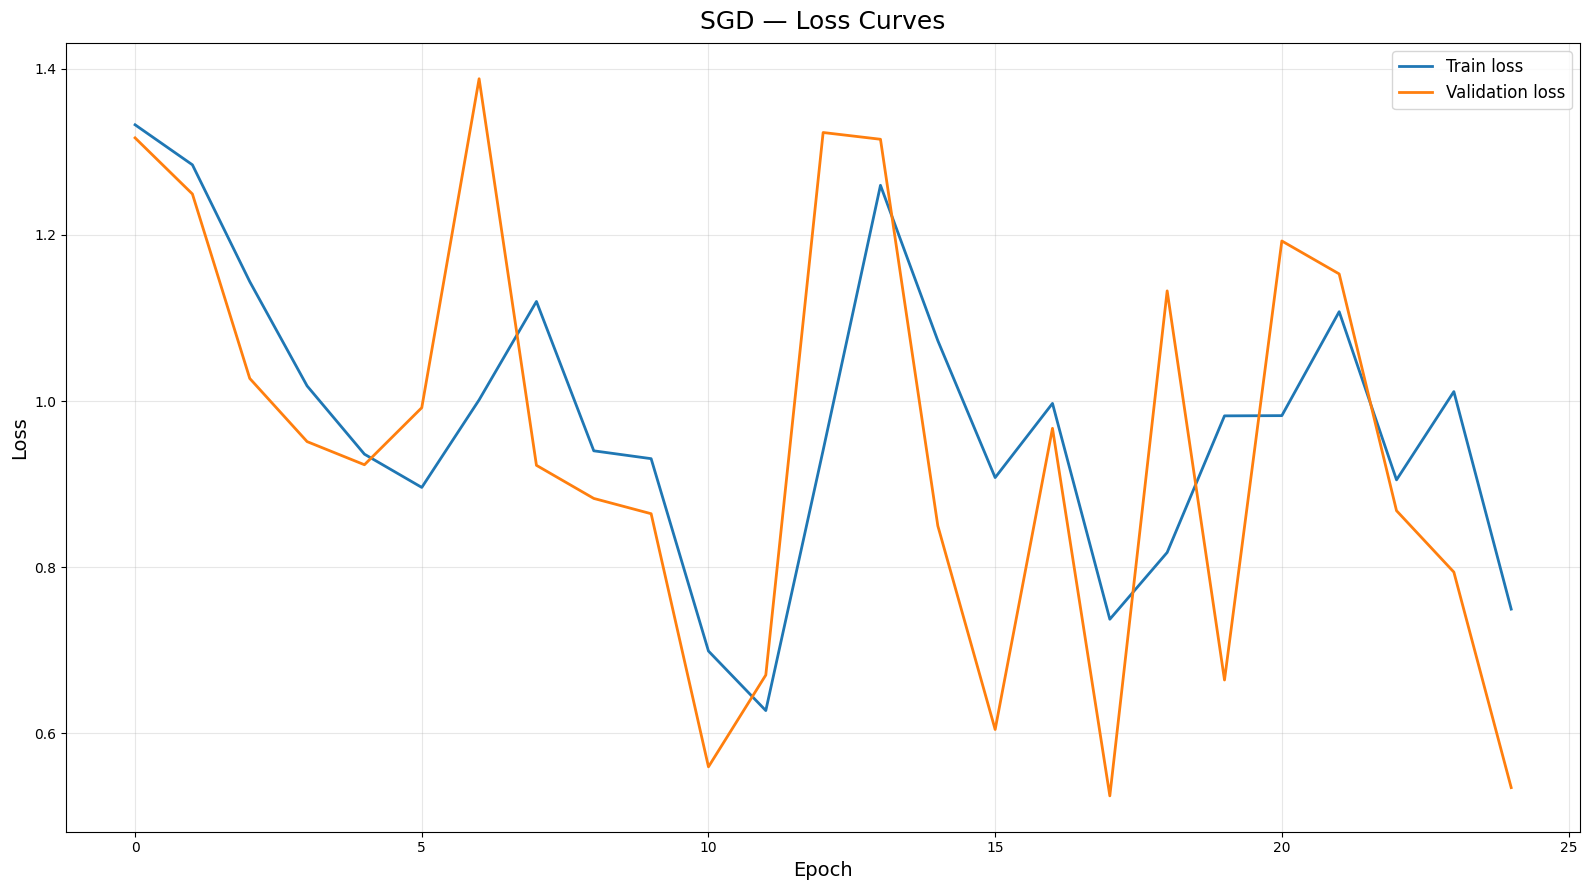

✅ Saved: figs/Adam_loss_curve.png


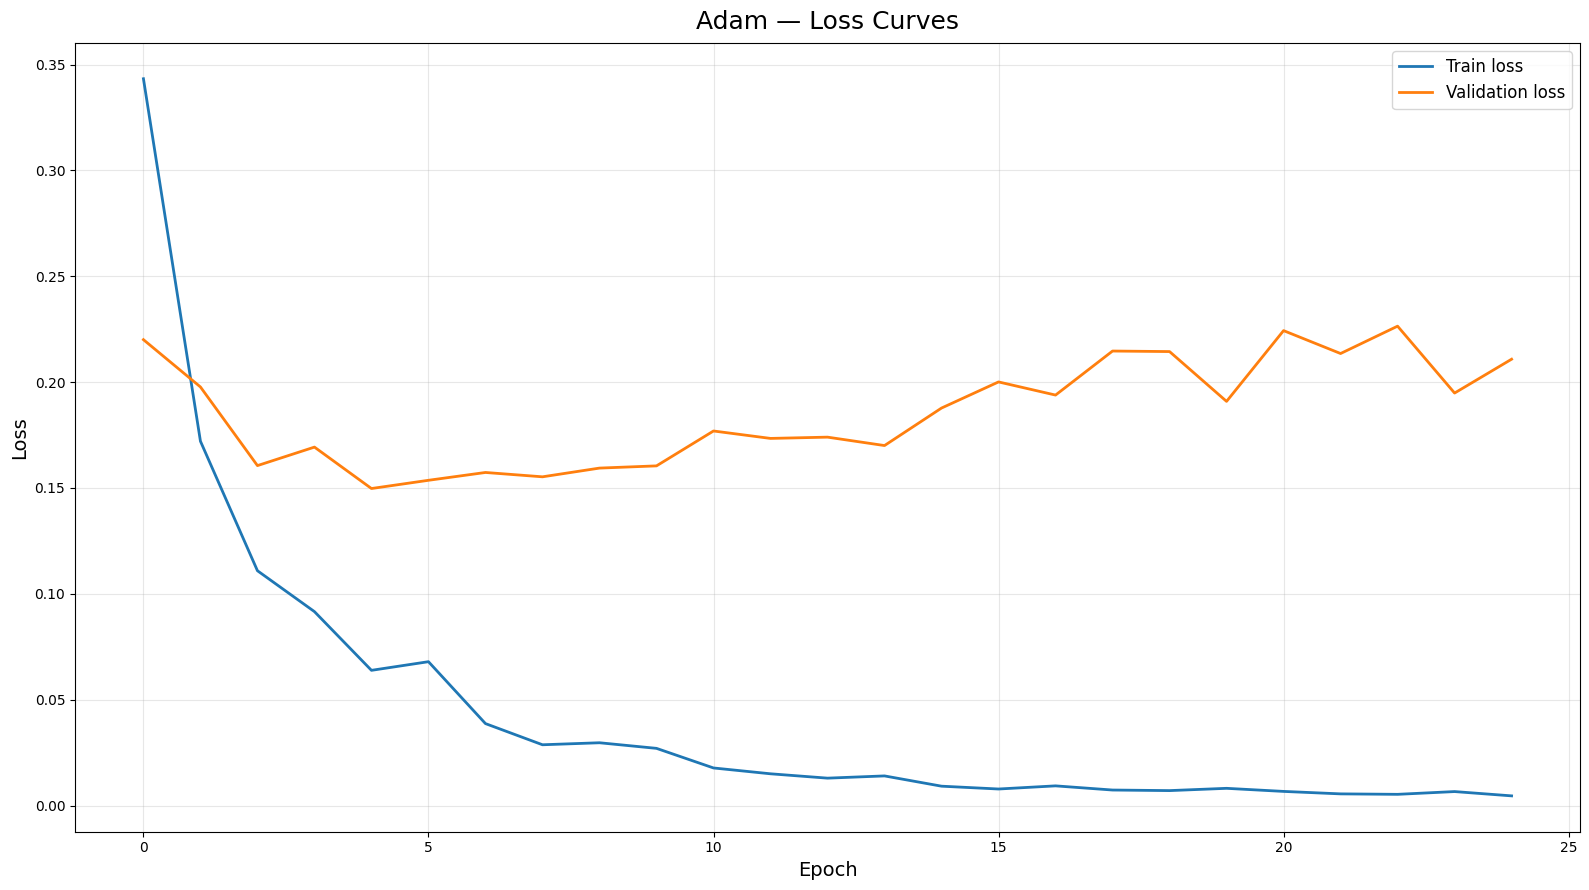

✅ Saved: figs/RMSProp_loss_curve.png


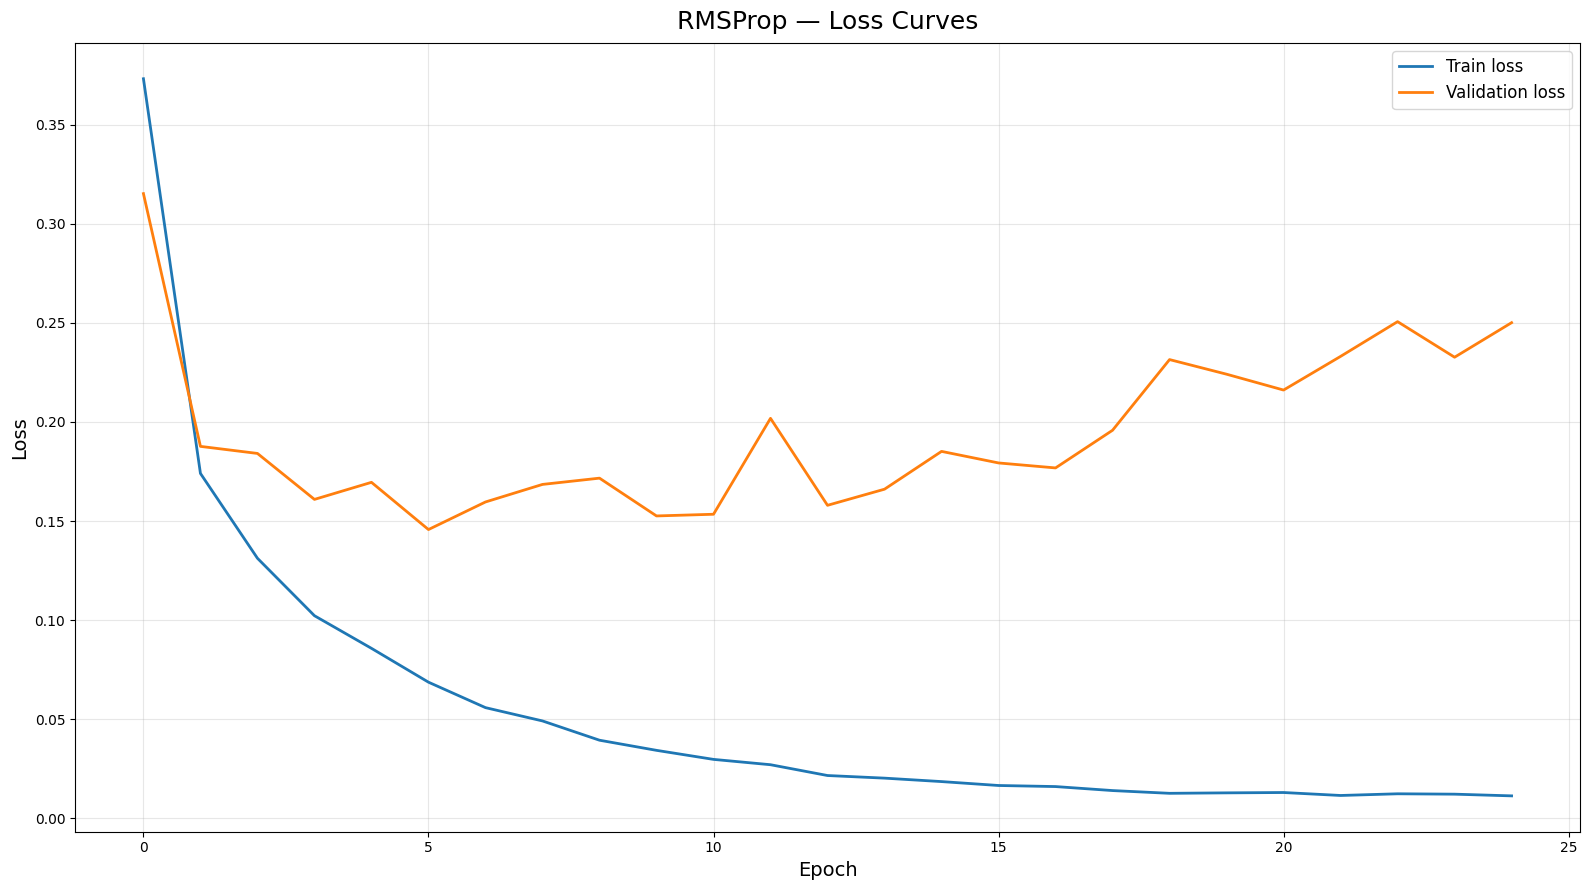

✅ Saved: figs/Adagrad_loss_curve.png


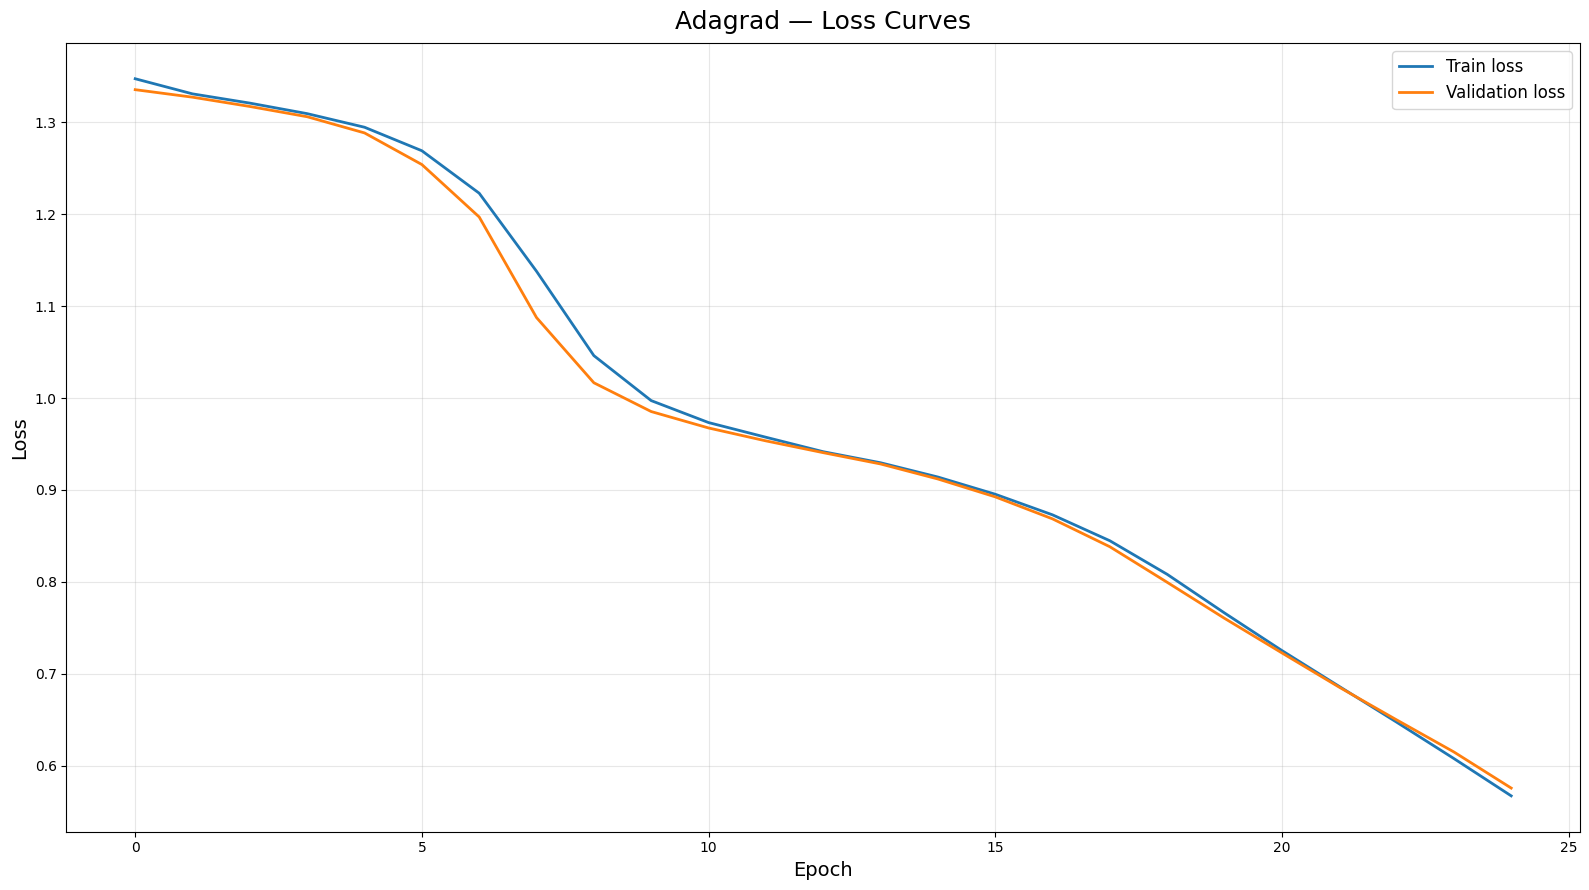

✅ Saved: figs/Nadam_loss_curve.png


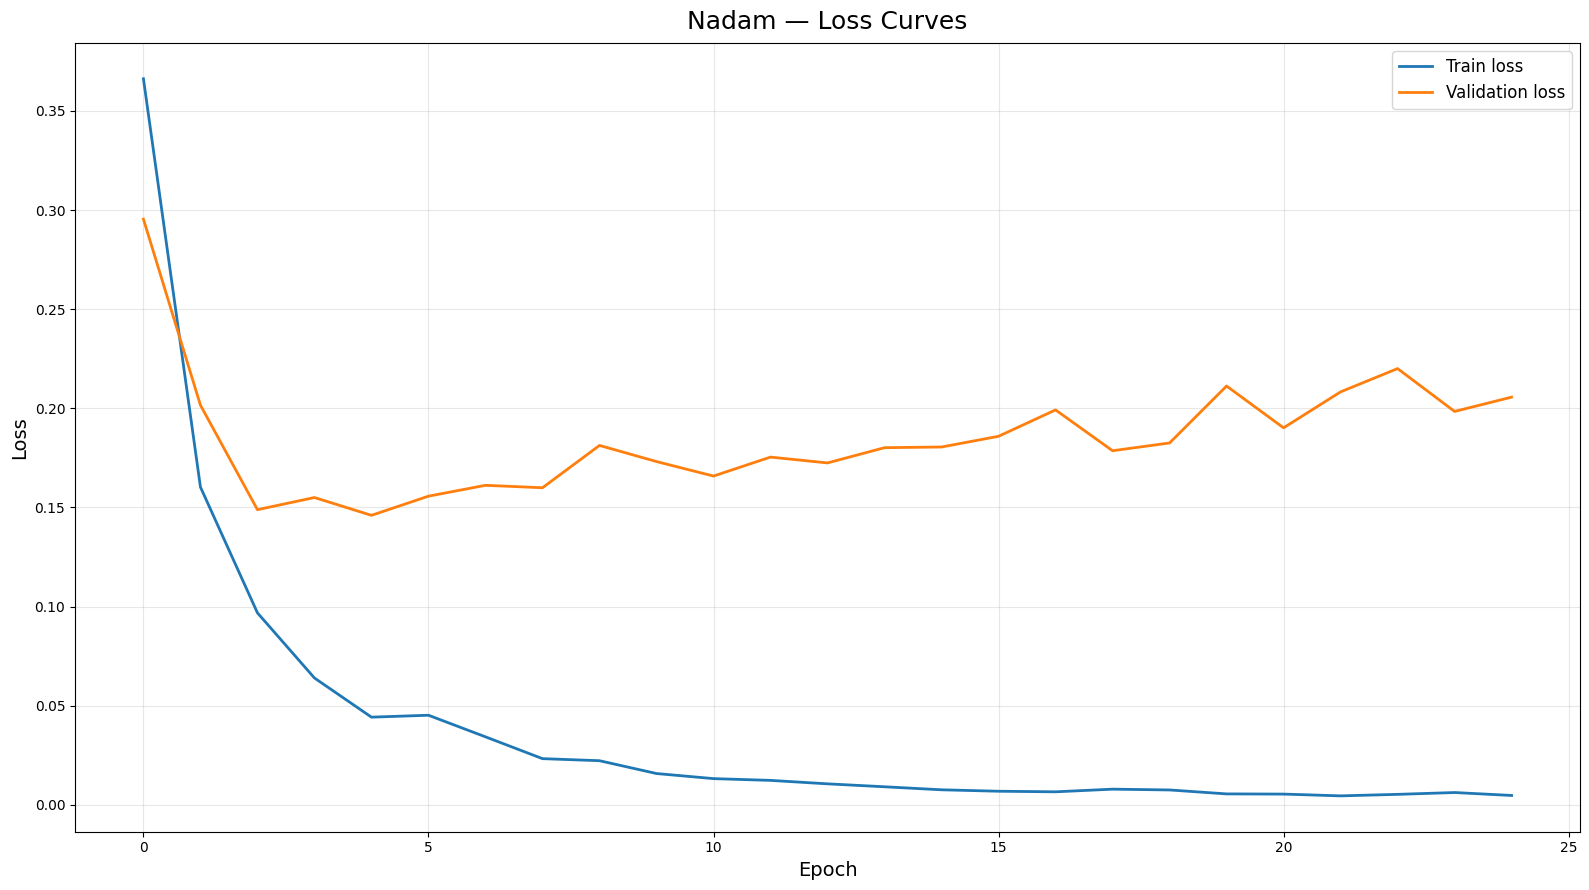

In [36]:
# ===== Learning curves (train vs val) for EACH optimizer — saved as images =====
import os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)  # folder to store images

def plot_histories(histories, metric="accuracy"):
    val_metric = "val_" + metric
    for name, h in histories.items():
        plt.figure(figsize=(16, 9))   # ✅ widescreen, no scroll
        plt.plot(h.history[metric], label=f"Train {metric}", linewidth=2)
        plt.plot(h.history[val_metric], label=f"Validation {metric}", linewidth=2)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.title(f"{name} — {metric.capitalize()} Curves", fontsize=18, pad=10)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # save as PNG
        fname = f"figs/{name}_{metric}_curve.png"
        plt.savefig(fname, dpi=200)
        print(f"✅ Saved: {fname}")
        plt.show()

# Generate both accuracy and loss plots
plot_histories(histories, metric="accuracy")
plot_histories(histories, metric="loss")



===== SGD — Classification Report =====
                        precision    recall  f1-score   support

                 Books       0.95      0.86      0.90      2364
Clothing & Accessories       0.77      0.94      0.85      1734
           Electronics       0.87      0.46      0.60      2124
             Household       0.74      0.90      0.81      3863

              accuracy                           0.81     10085
             macro avg       0.83      0.79      0.79     10085
          weighted avg       0.82      0.81      0.80     10085

✅ Saved: figs/confusion_matrix_SGD.png


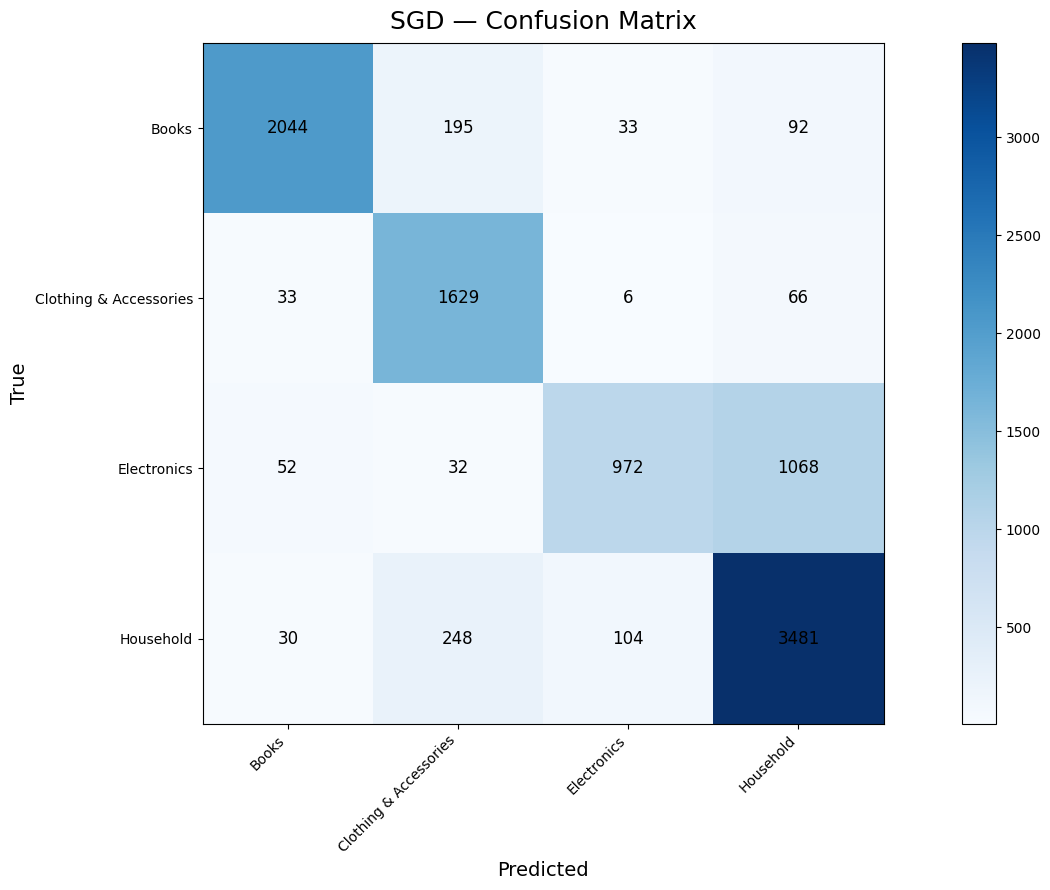


===== Adam — Classification Report =====
                        precision    recall  f1-score   support

                 Books       0.97      0.97      0.97      2364
Clothing & Accessories       0.96      0.99      0.97      1734
           Electronics       0.97      0.97      0.97      2124
             Household       0.98      0.97      0.97      3863

              accuracy                           0.97     10085
             macro avg       0.97      0.97      0.97     10085
          weighted avg       0.97      0.97      0.97     10085

✅ Saved: figs/confusion_matrix_Adam.png


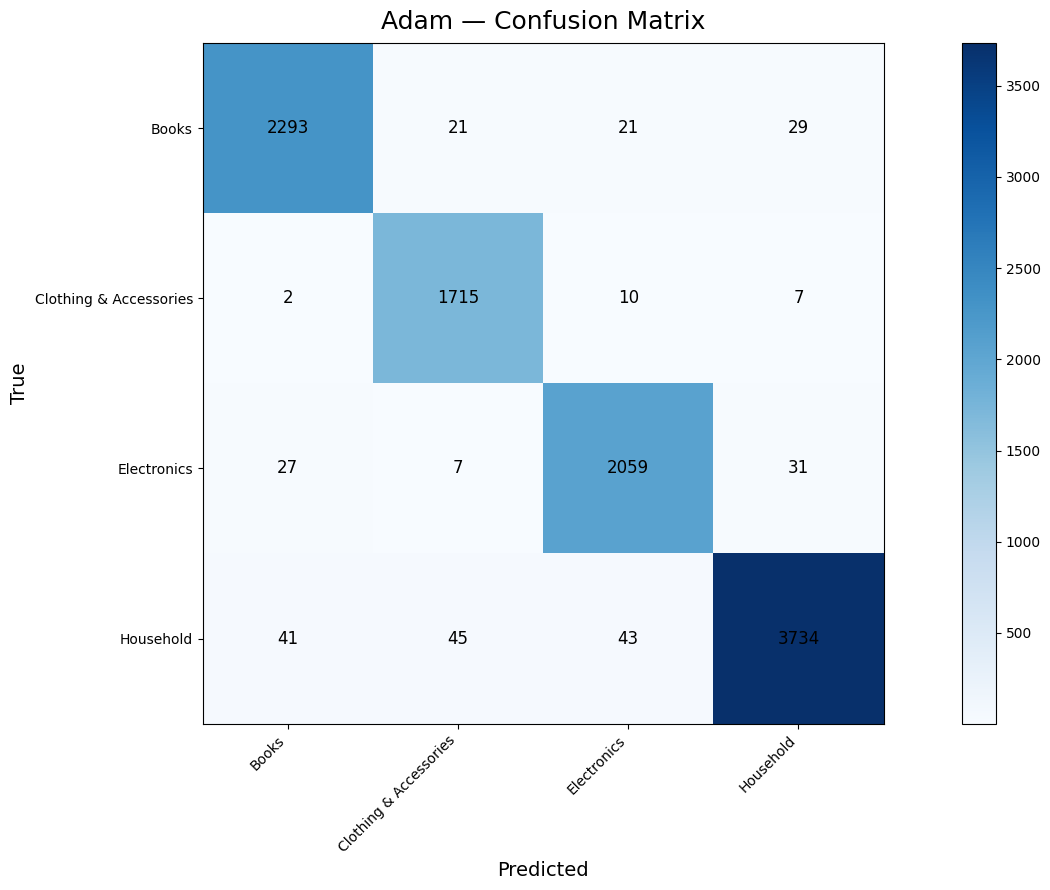


===== RMSProp — Classification Report =====
                        precision    recall  f1-score   support

                 Books       0.97      0.97      0.97      2364
Clothing & Accessories       0.98      0.98      0.98      1734
           Electronics       0.97      0.97      0.97      2124
             Household       0.97      0.98      0.98      3863

              accuracy                           0.98     10085
             macro avg       0.98      0.97      0.98     10085
          weighted avg       0.98      0.98      0.98     10085

✅ Saved: figs/confusion_matrix_RMSProp.png


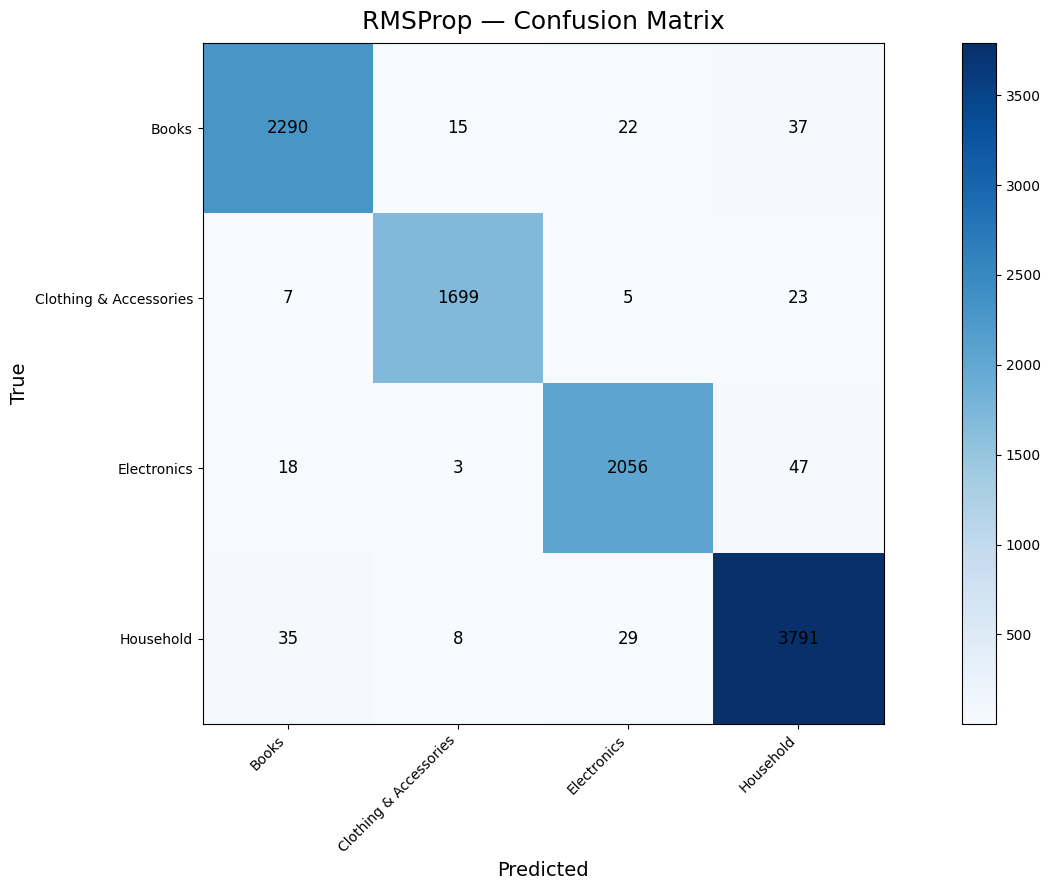


===== Adagrad — Classification Report =====
                        precision    recall  f1-score   support

                 Books       0.89      0.92      0.90      2364
Clothing & Accessories       0.69      0.75      0.72      1734
           Electronics       0.72      0.65      0.68      2124
             Household       0.89      0.89      0.89      3863

              accuracy                           0.82     10085
             macro avg       0.80      0.80      0.80     10085
          weighted avg       0.82      0.82      0.82     10085

✅ Saved: figs/confusion_matrix_Adagrad.png


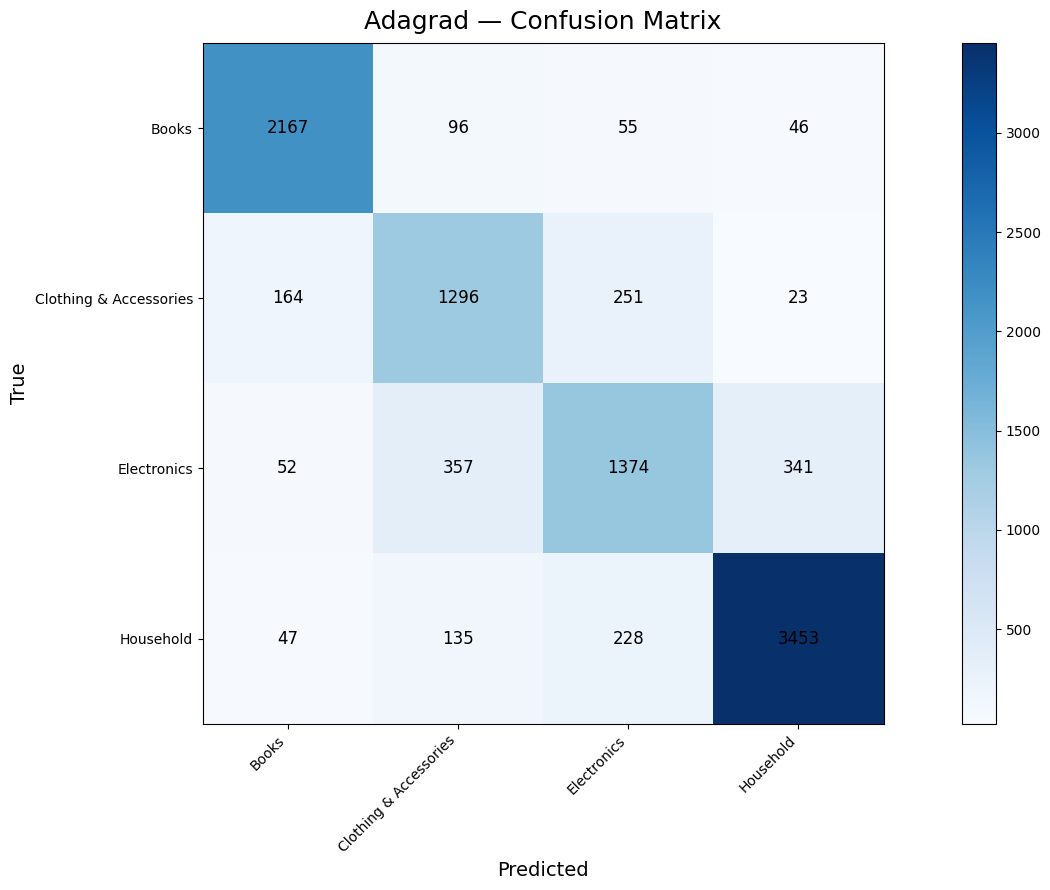


===== Nadam — Classification Report =====
                        precision    recall  f1-score   support

                 Books       0.98      0.96      0.97      2364
Clothing & Accessories       0.98      0.99      0.98      1734
           Electronics       0.97      0.97      0.97      2124
             Household       0.98      0.98      0.98      3863

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085

✅ Saved: figs/confusion_matrix_Nadam.png


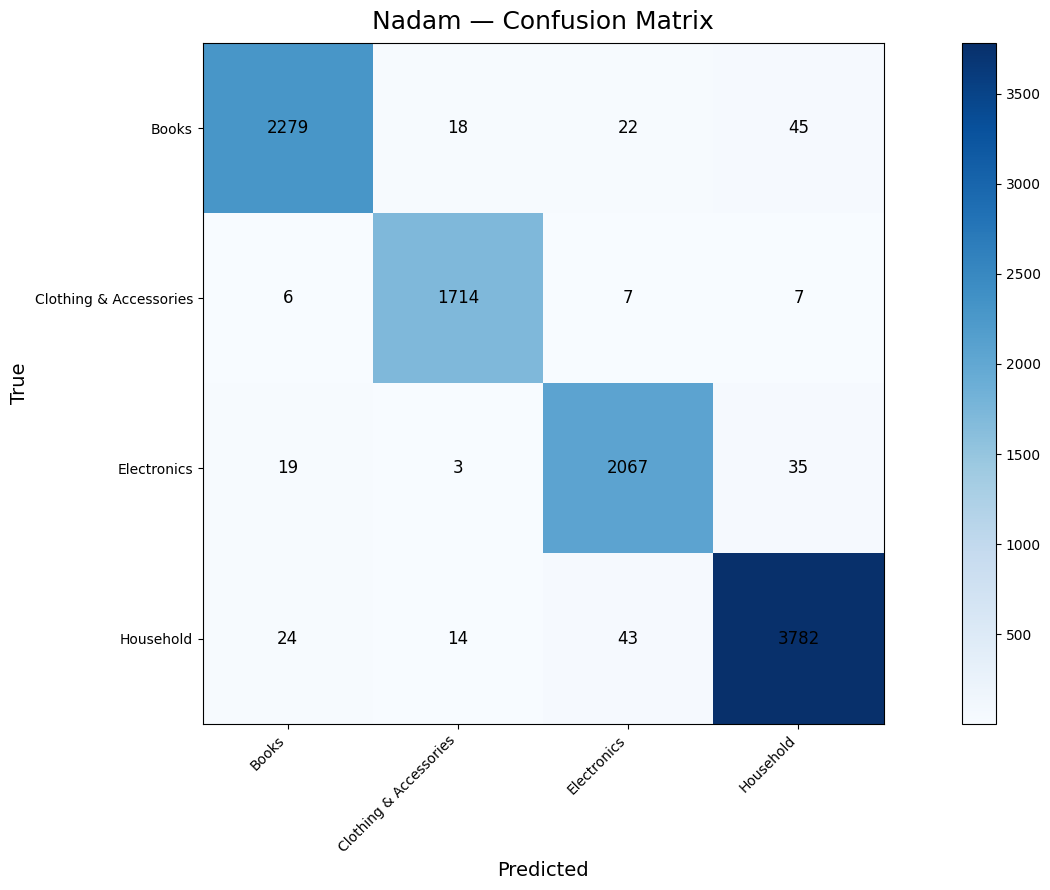


=== PER-CLASS METRICS (precision / recall / f1 / support) ===


,optimizer,class,precision,recall,f1,support
12,Adagrad,Books,0.891770,0.916667,0.904047,2364.0
4,Adam,Books,0.970377,0.969966,0.970171,2364.0
16,Nadam,Books,0.978952,0.964044,0.971441,2364.0
8,RMSProp,Books,0.974468,0.968697,0.971574,2364.0
0,SGD,Books,0.946735,0.864636,0.903825,2364.0
13,Adagrad,Clothing & Accessories,0.687898,0.747405,0.716418,1734.0
5,Adam,Clothing & Accessories,0.959172,0.989043,0.973878,1734.0
17,Nadam,Clothing & Accessories,0.979989,0.988466,0.984209,1734.0
9,RMSProp,Clothing & Accessories,0.984928,0.979815,0.982365,1734.0
1,SGD,Clothing & Accessories,0.774240,0.939446,0.848880,1734.0


✅ Saved: figs/per_class_metrics.csv
✅ Saved: figs/per_class_f1_Books.png


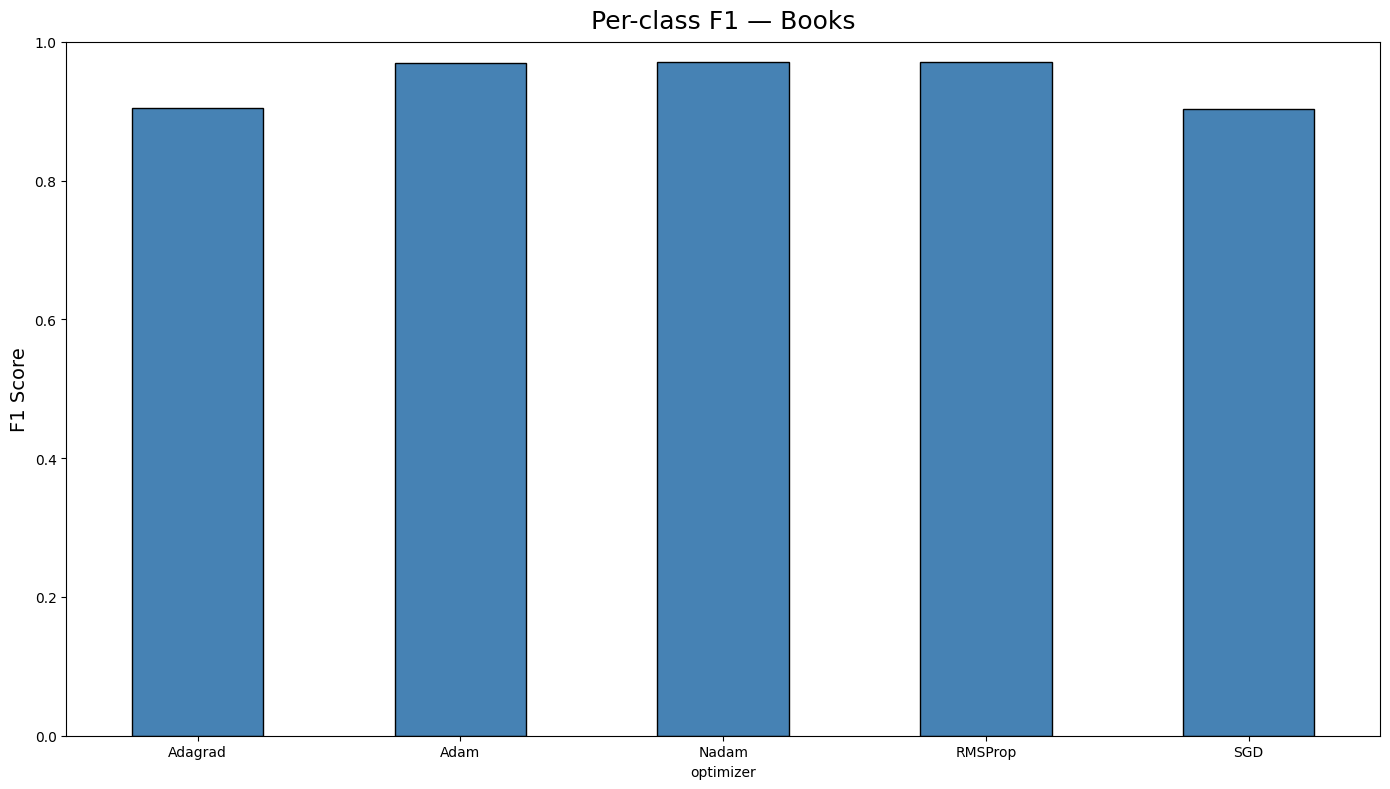

✅ Saved: figs/per_class_f1_Clothing_&_Accessories.png


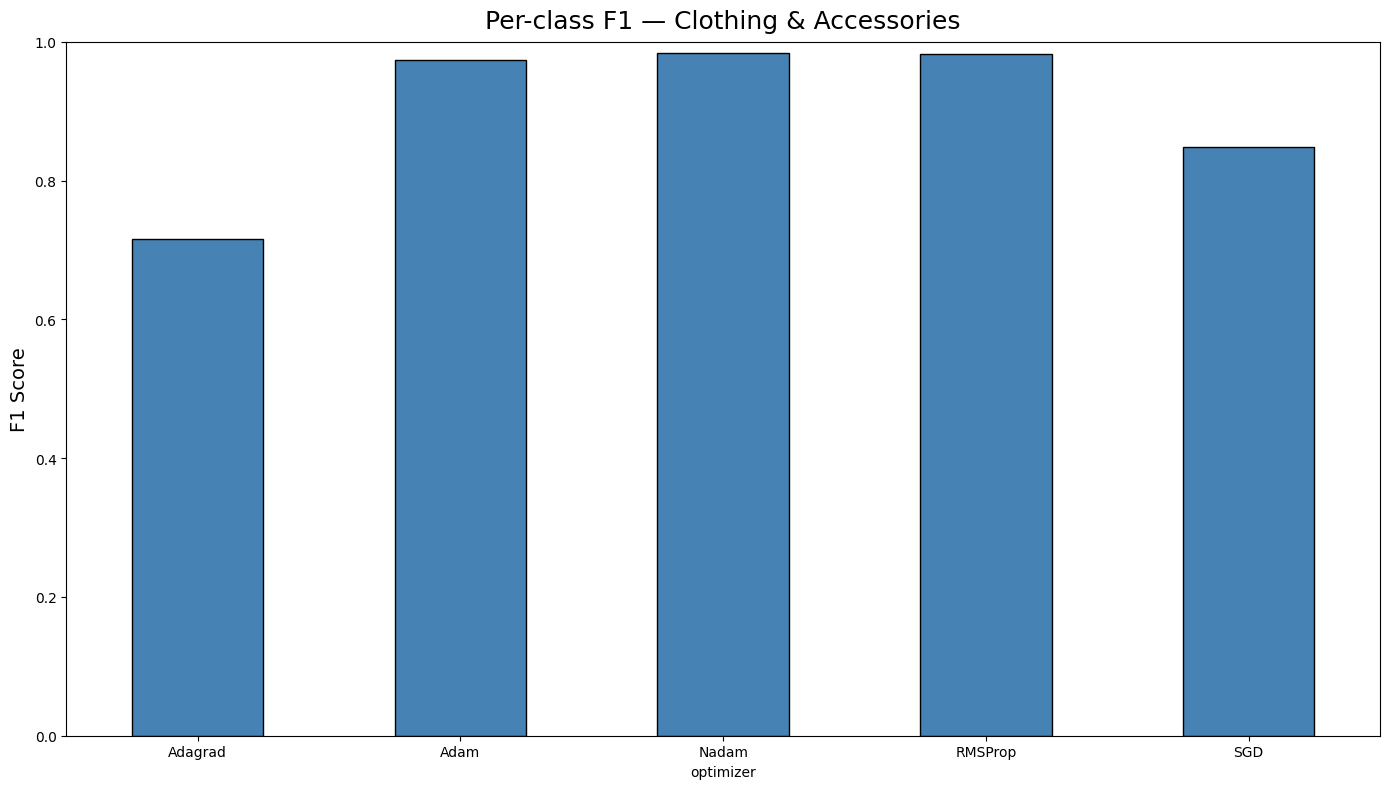

✅ Saved: figs/per_class_f1_Electronics.png


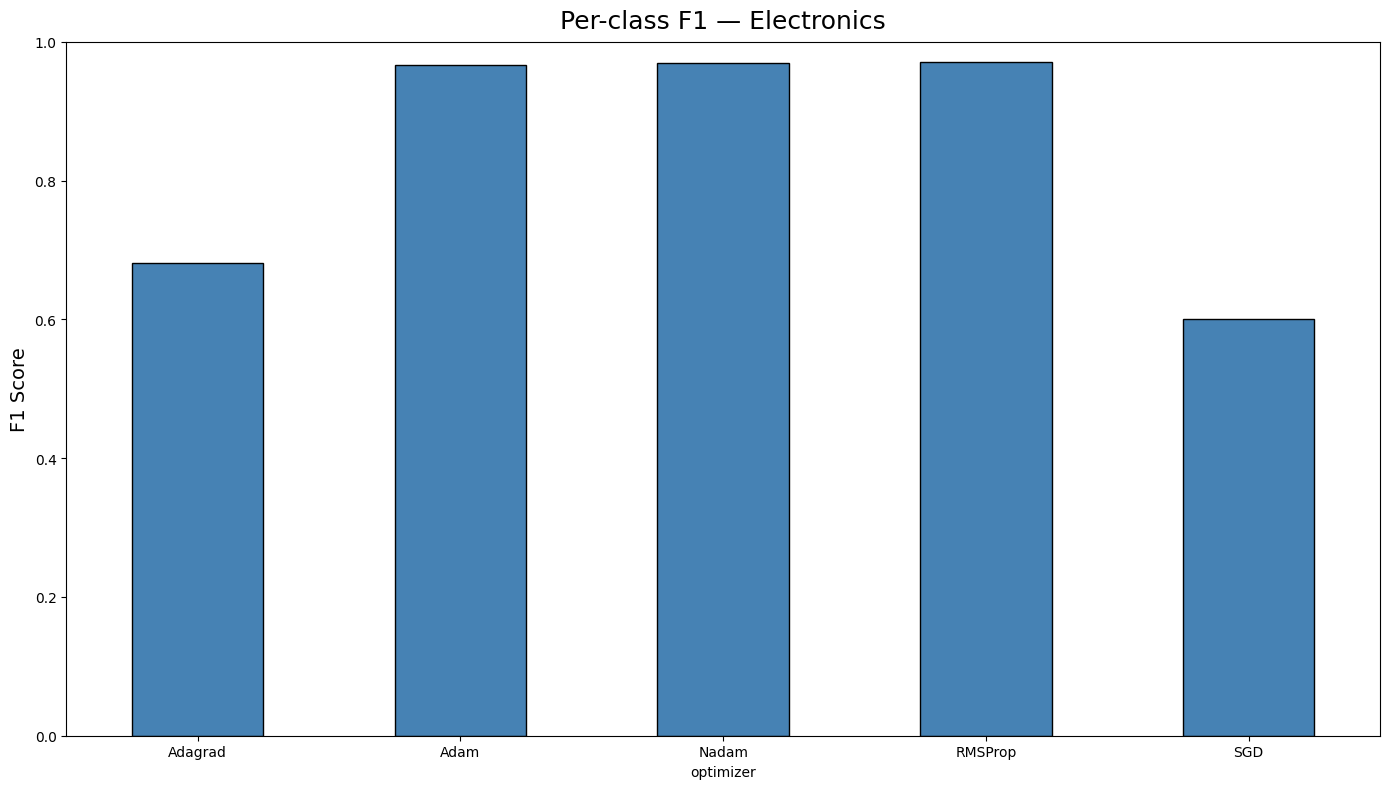

✅ Saved: figs/per_class_f1_Household.png


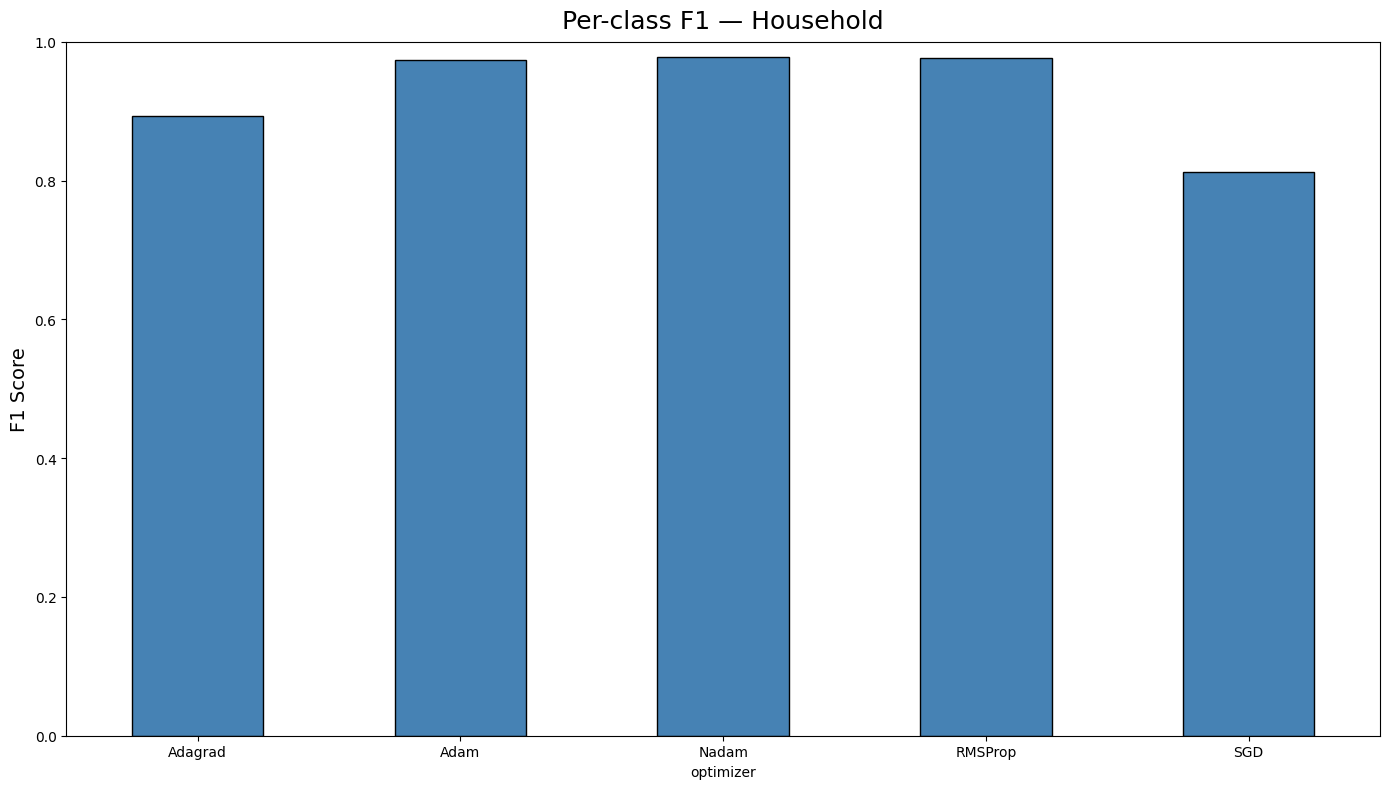


🏆 SCOREBOARD: {
  "best_final_val_acc": "SGD",
  "best_final_val_loss": "RMSProp"
}


In [37]:
# ===== CONFUSION MATRICES & PER-CLASS METRICS — SAVED AS IMAGES =====
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ensure folder
os.makedirs("figs", exist_ok=True)

label_names = list(le.classes_)
reports, cms = {}, {}

# ---------- CONFUSION MATRICES ----------
for name, model in models.items():
    y_pred = model.predict(Xte, verbose=0).argmax(axis=1)
    rep = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
    reports[name] = rep
    cm = confusion_matrix(y_test, y_pred)
    cms[name] = cm

    # print report
    print(f"\n===== {name} — Classification Report =====")
    print(classification_report(y_test, y_pred, target_names=label_names))

    # plot confusion matrix
    plt.figure(figsize=(16,9))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix", fontsize=18, pad=10)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(label_names)), label_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12, color="black")
    plt.colorbar()
    plt.tight_layout()

    # save image
    fname = f"figs/confusion_matrix_{name}.png"
    plt.savefig(fname, dpi=200)
    print(f"✅ Saved: {fname}")
    plt.show()

# ---------- PER-CLASS METRICS ----------
rows = []
for name, rep in reports.items():
    for cls in label_names:
        if cls in rep:
            rows.append({
                "optimizer": name,
                "class": cls,
                "precision": rep[cls]["precision"],
                "recall": rep[cls]["recall"],
                "f1": rep[cls]["f1-score"],
                "support": rep[cls]["support"],
            })

per_class_df = pd.DataFrame(rows).sort_values(["class", "optimizer"])
print("\n=== PER-CLASS METRICS (precision / recall / f1 / support) ===")
display(per_class_df)
per_class_df.to_csv("figs/per_class_metrics.csv", index=False)
print("✅ Saved: figs/per_class_metrics.csv")

# ---------- PER-CLASS F1 VISUALS ----------
for cls in label_names:
    sub = per_class_df[per_class_df["class"] == cls].set_index("optimizer").sort_index()
    plt.figure(figsize=(14,8))
    sub["f1"].plot(kind="bar", color="steelblue", edgecolor="black")
    plt.ylim(0, 1)
    plt.ylabel("F1 Score", fontsize=14)
    plt.title(f"Per-class F1 — {cls}", fontsize=18, pad=10)
    plt.xticks(rotation=0)
    plt.tight_layout()

    fname = f"figs/per_class_f1_{cls.replace(' ', '_')}.png"
    plt.savefig(fname, dpi=200)
    print(f"✅ Saved: {fname}")
    plt.show()

# ---------- SCOREBOARD ----------
winners = {
    "best_final_val_acc": res_df.index[0],
    "best_final_val_loss": res_df["final_val_loss"].idxmin()
}
print("\n🏆 SCOREBOARD:", json.dumps(winners, indent=2))
